#  Don't forget to upvote if you like my notebook. :)

#  Import Libraries

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import ElasticNetCV,LassoCV,RidgeCV
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense,Dropout,LeakyReLU

from keras.callbacks import ModelCheckpoint
from keras.models import load_model


from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('./train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_train.drop('Id',axis=1,inplace=True)

In [4]:
def visualNA(df,perc=0):
    #Percentage of NAN Values 
    NAN = [(c, df[c].isna().mean()*100) for c in df]
    NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])
    NAN = NAN[NAN.percentage > perc]
    print(NAN.sort_values("percentage", ascending=False))
    

In [5]:

visualNA(df_train)

     column_name  percentage
71        PoolQC   99.520548
73   MiscFeature   96.301370
5          Alley   93.767123
72         Fence   80.753425
56   FireplaceQu   47.260274
2    LotFrontage   17.739726
57    GarageType    5.547945
58   GarageYrBlt    5.547945
59  GarageFinish    5.547945
62    GarageQual    5.547945
63    GarageCond    5.547945
31  BsmtExposure    2.602740
34  BsmtFinType2    2.602740
32  BsmtFinType1    2.534247
30      BsmtCond    2.534247
29      BsmtQual    2.534247
25    MasVnrArea    0.547945
24    MasVnrType    0.547945
41    Electrical    0.068493


Most of the notebooks are dropping missing percentage values due to its sheer size of missing value percentage but these missing values make insignificant impact on pricing as well as insights that we will see later our findings.

In [6]:
def handleNA(df):
    df['Alley'].fillna(value='No alley access',inplace=True)    
    df['BsmtQual'].fillna(value='No Basement',inplace=True)
    df['BsmtCond'].fillna(value='No Basement',inplace=True)
    df['BsmtExposure'].fillna(value='No Basement',inplace=True)
    df['BsmtFinType1'].fillna(value='No Basement',inplace=True)    
    df['BsmtFinType2'].fillna(value='No Basement',inplace=True)    
    df['FireplaceQu'].fillna(value='No Fireplace',inplace=True)    
    df['GarageType'].fillna(value='No Garage',inplace=True)  
    df['GarageYrBlt'].fillna(value=0,inplace=True)
    df['GarageFinish'].fillna(value='No Garage',inplace=True)
    df['GarageQual'].fillna(value='No Garage',inplace=True)
    df['GarageCond'].fillna(value='No Garage',inplace=True)
    df['MasVnrType'].fillna(value='None',inplace=True)
    df['MasVnrArea'].fillna(value=0.0,inplace=True)
    df['PoolQC'].fillna(value='No Pool',inplace=True)    
    df['Fence'].fillna(value='No Fence',inplace=True)
    df['MiscFeature'].fillna(value='None',inplace=True)
    
    

In [7]:
handleNA(df_train)

In [8]:

visualNA(df_train)

    column_name  percentage
2   LotFrontage   17.739726
41   Electrical    0.068493


In [9]:
df_train[df_train['Electrical'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,80,RL,73.0,9735,Pave,No alley access,Reg,Lvl,AllPub,Inside,...,0,No Pool,No Fence,None,0,5,2008,WD,Normal,167500


In [10]:
df_train[(df_train['Electrical'].notnull()) & (df_train['MSSubClass']==80) 
        & (df_train['LotFrontage']==73) ]['Electrical']

731    SBrkr
Name: Electrical, dtype: object

In [11]:
df_train.loc[df_train['Electrical'].isnull(),'Electrical'] = 'SBrkr'

From above data cleaning and transformation we got to know that only Lot Frontage is the column which need to be handle for its missing value and It will be done at the time of data modelling for price predictions.

In [12]:
dict_neighbor = {
'NAmes'  :{'lat': 42.045830,'lon': -93.620767},
'CollgCr':{'lat': 42.018773,'lon': -93.685543},
'OldTown':{'lat': 42.030152,'lon': -93.614628},
'Edwards':{'lat': 42.021756,'lon': -93.670324},
'Somerst':{'lat': 42.050913,'lon': -93.644629},
'Gilbert':{'lat': 42.060214,'lon': -93.643179},
'NridgHt':{'lat': 42.060357,'lon': -93.655263},
'Sawyer' :{'lat': 42.034446,'lon': -93.666330},
'NWAmes' :{'lat': 42.049381,'lon': -93.634993},
'SawyerW':{'lat': 42.033494,'lon': -93.684085},
'BrkSide':{'lat': 42.032422,'lon': -93.626037},
'Crawfor':{'lat': 42.015189,'lon': -93.644250},
'Mitchel':{'lat': 41.990123,'lon': -93.600964},
'NoRidge':{'lat': 42.051748,'lon': -93.653524},
'Timber' :{'lat': 41.998656,'lon': -93.652534},
'IDOTRR' :{'lat': 42.022012,'lon': -93.622183},
'ClearCr':{'lat': 42.060021,'lon': -93.629193},
'StoneBr':{'lat': 42.060227,'lon': -93.633546},
'SWISU'  :{'lat': 42.022646,'lon': -93.644853}, 
'MeadowV':{'lat': 41.991846,'lon': -93.603460},
'Blmngtn':{'lat': 42.059811,'lon': -93.638990},
'BrDale' :{'lat': 42.052792,'lon': -93.628820},
'Veenker':{'lat': 42.040898,'lon': -93.651502},
'NPkVill':{'lat': 42.049912,'lon': -93.626546},
'Blueste':{'lat': 42.010098,'lon': -93.647269}
}

In [13]:
df_train['Lat'] = df_train['Neighborhood'].map(lambda neighbor: dict_neighbor[neighbor]['lat'])
df_train['Lon'] = df_train['Neighborhood'].map(lambda neighbor: dict_neighbor[neighbor]['lon'])

# Data Visualization

In [14]:
Categorical_features = df_train.select_dtypes(include=['object'])
Numerical_features = df_train.select_dtypes(exclude=['object'])

In [15]:
Numerical_features.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'Lat', 'Lon'],
      dtype='object')

## Distribution of numerical features

In [16]:
def plotdist(data):
    try:
        sns.distplot(data)
    except RuntimeError as re:
        if str(re).startswith("Selected KDE bandwidth is 0. Cannot estimate density."):
            sns.distplot(data, kde_kws={'bw': 0.1})
        else:
            raise re

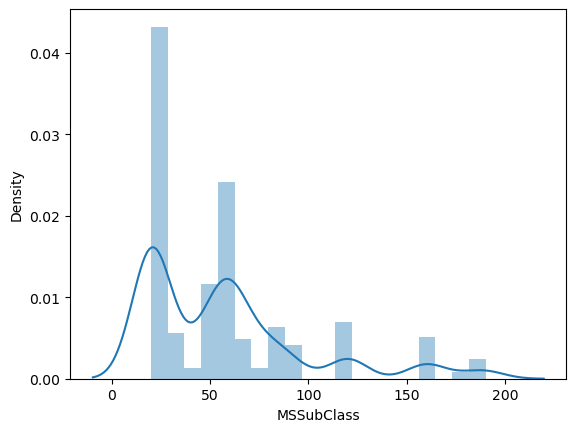

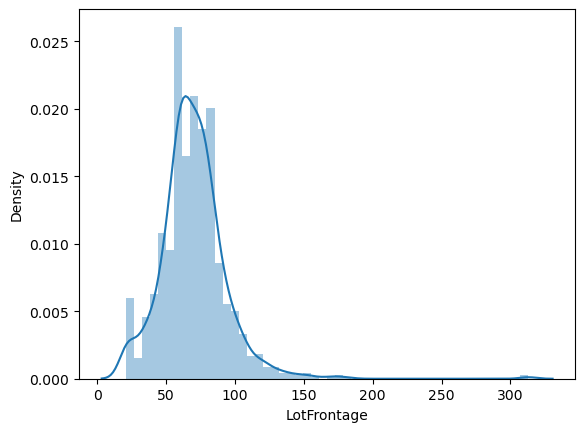

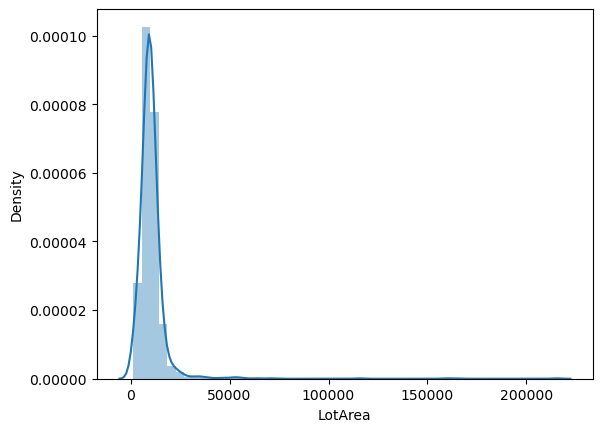

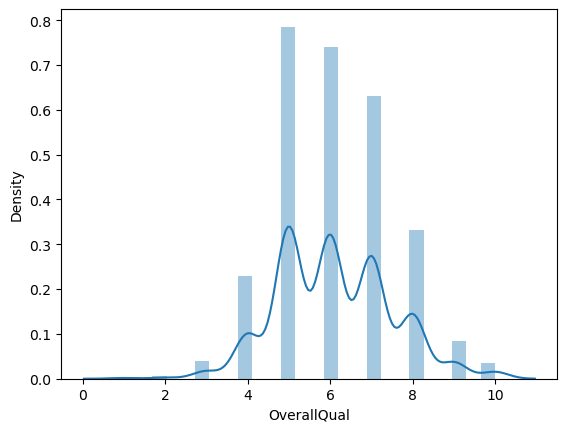

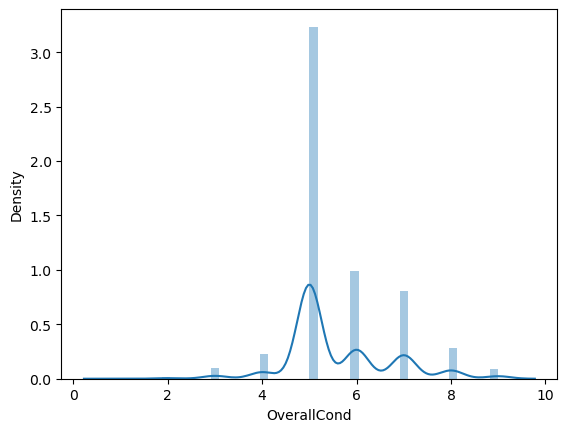

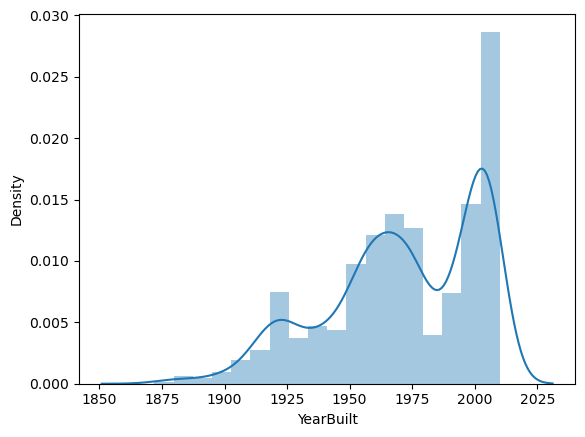

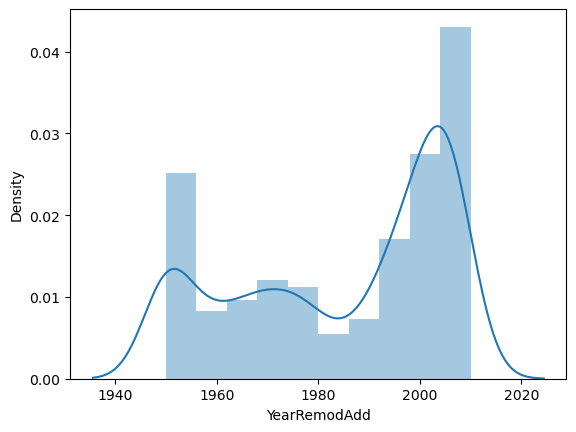

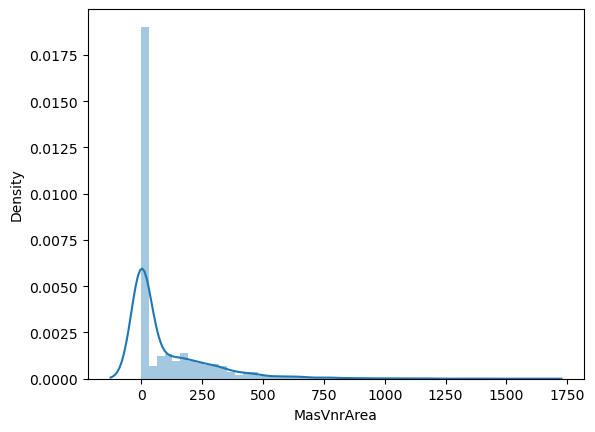

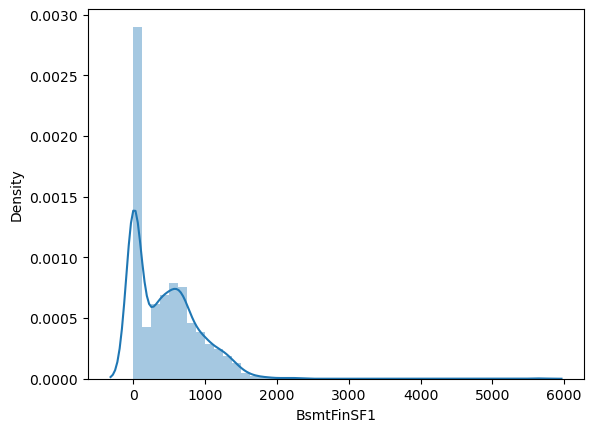

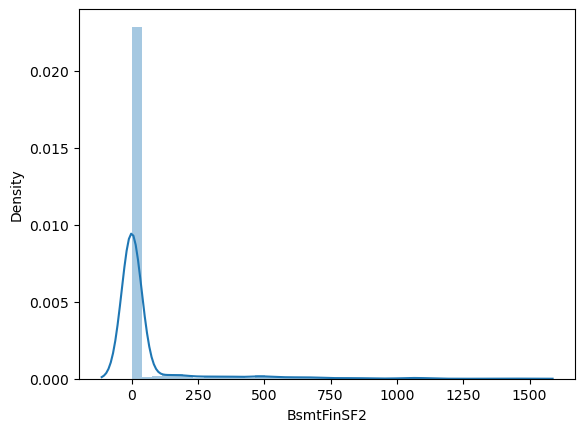

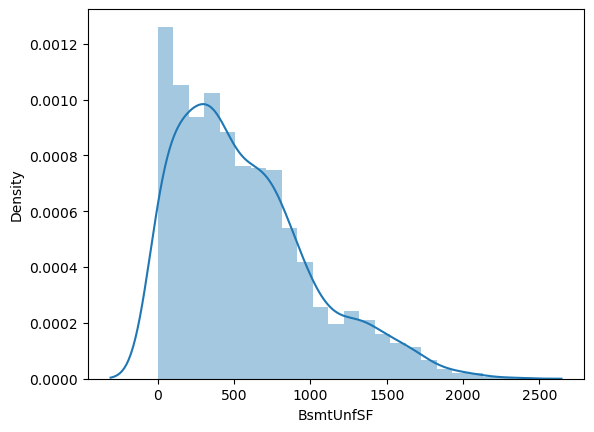

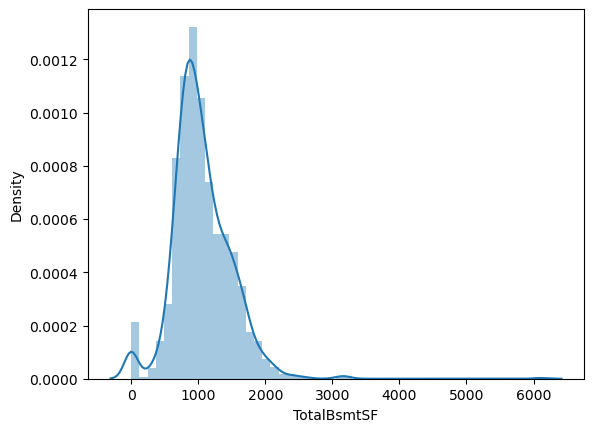

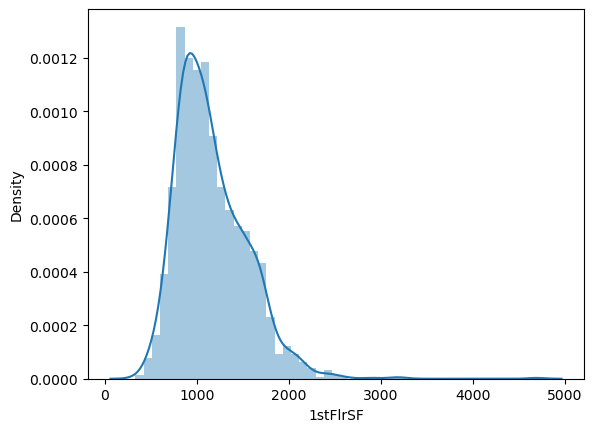

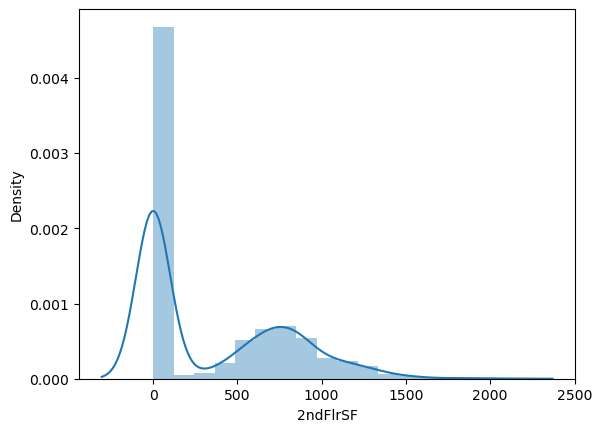

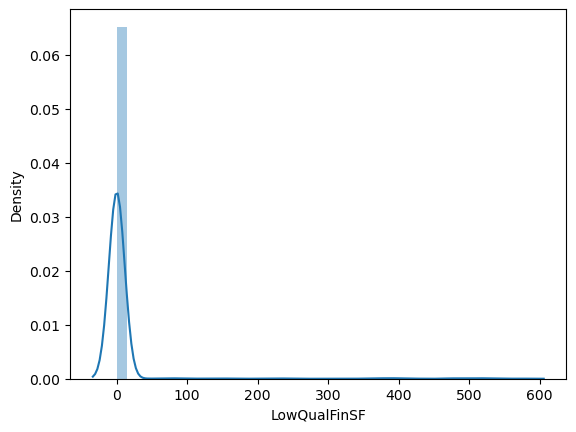

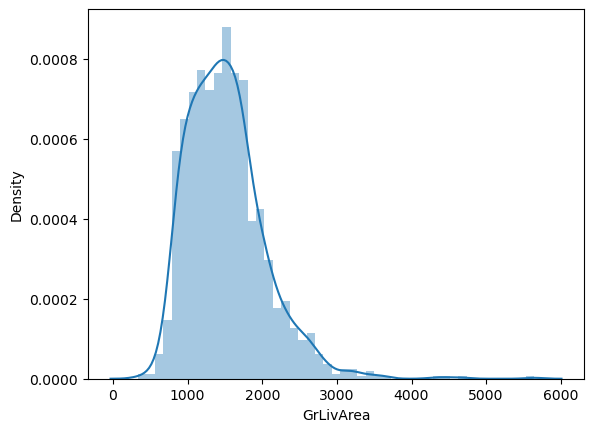

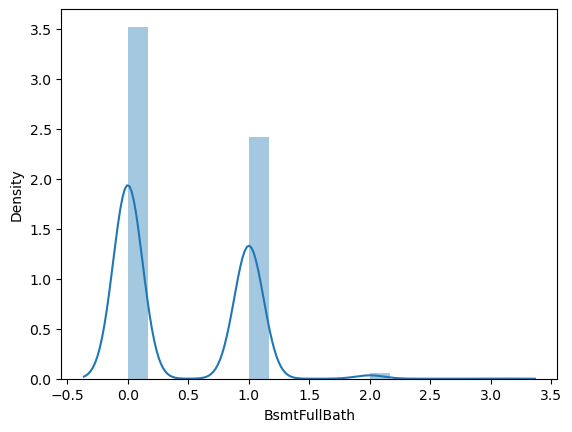

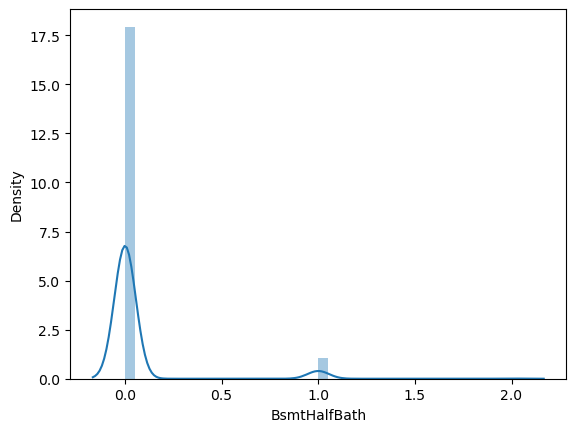

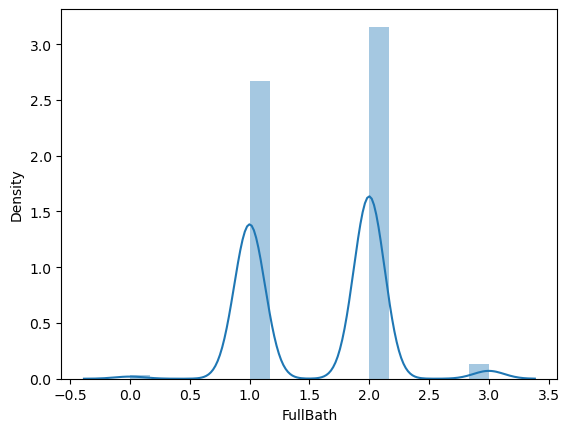

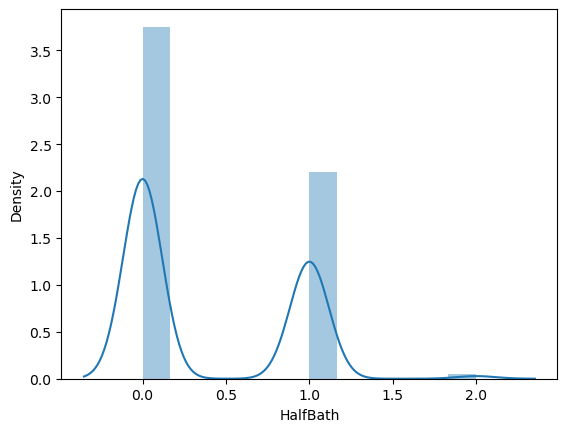

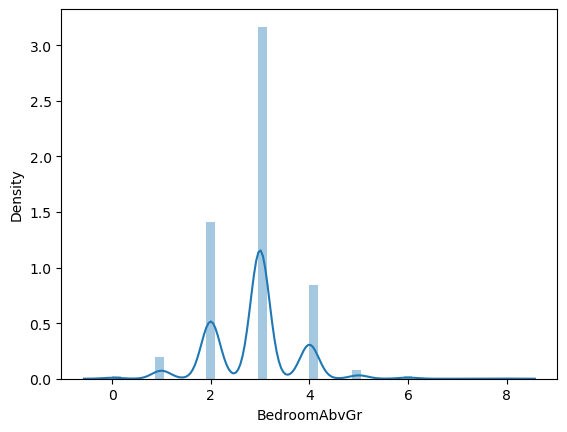

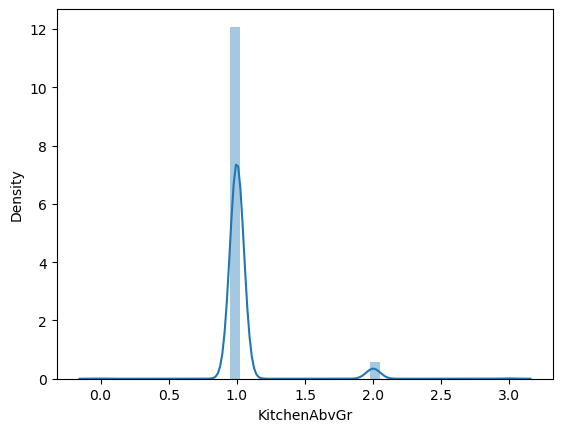

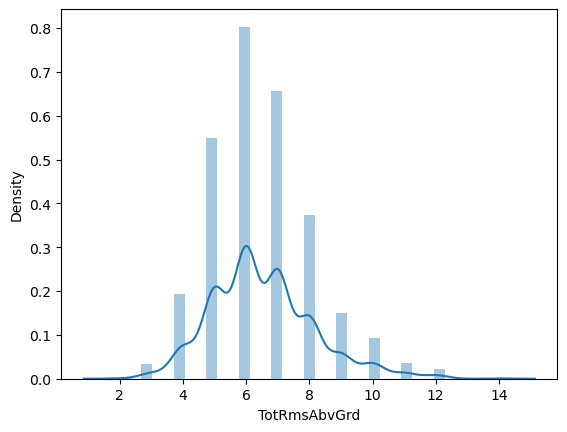

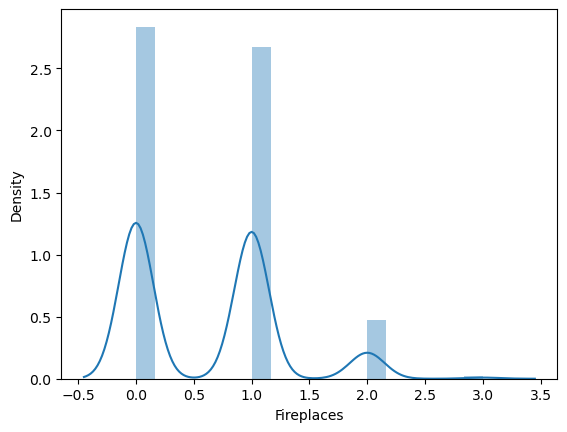

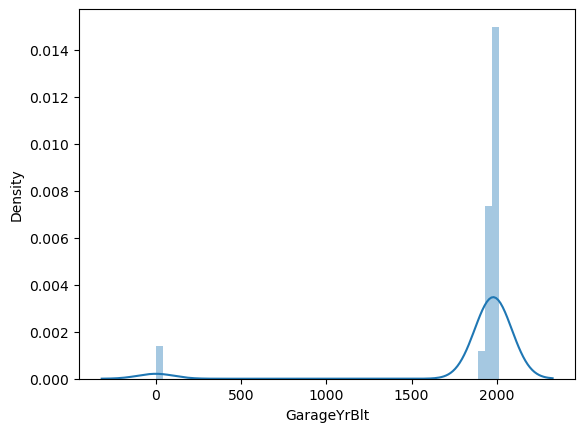

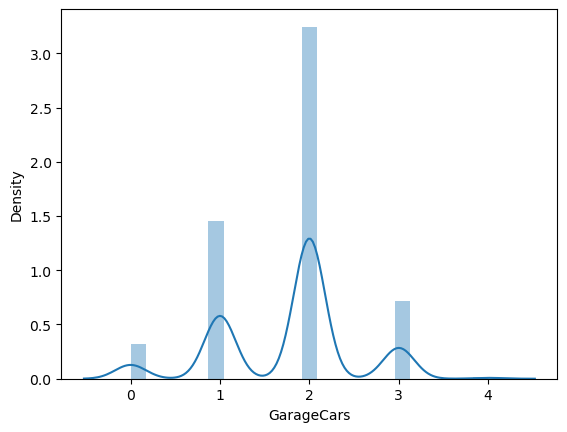

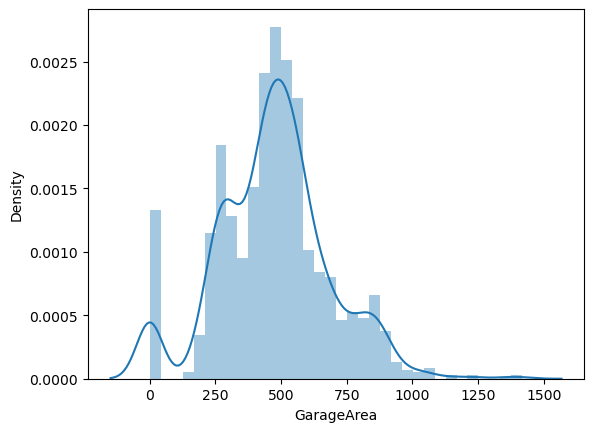

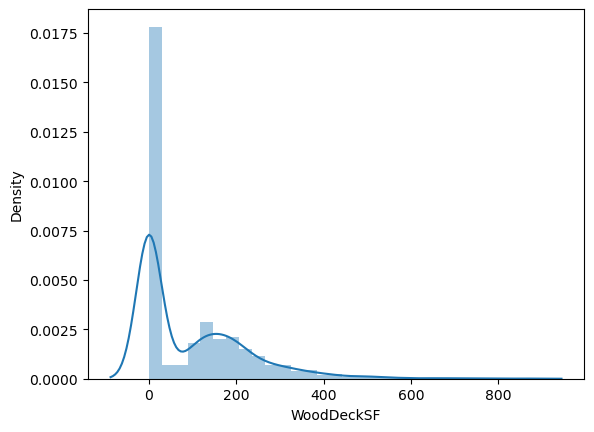

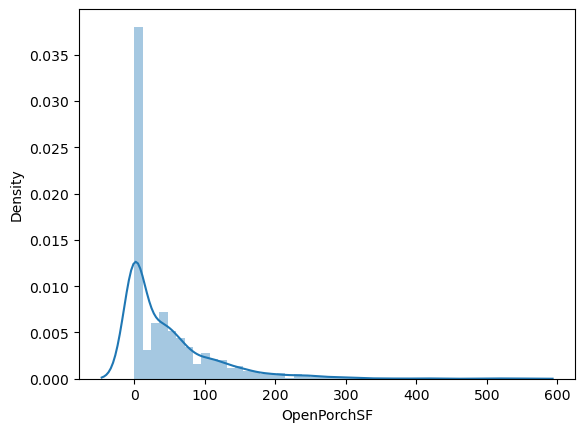

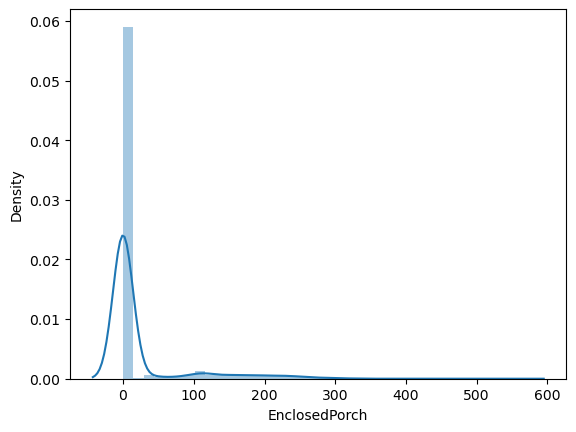

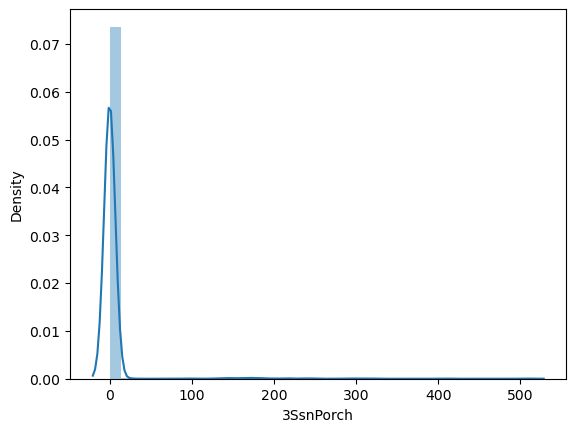

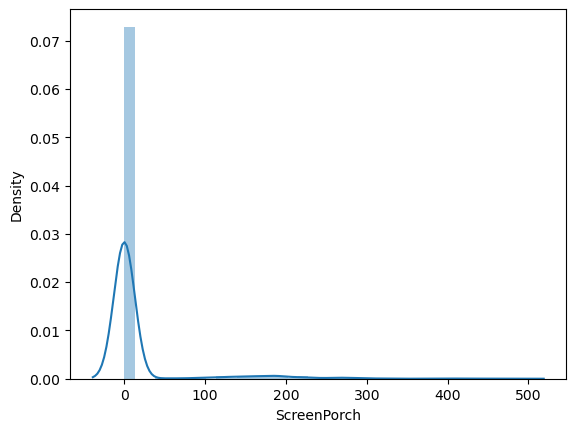

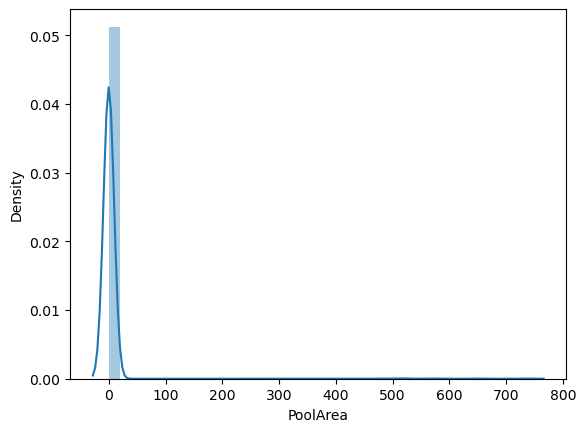

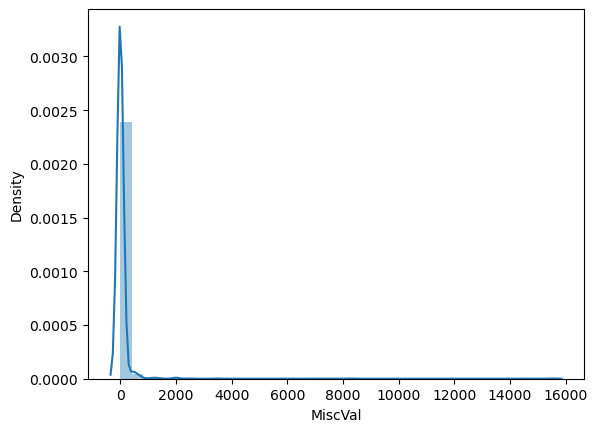

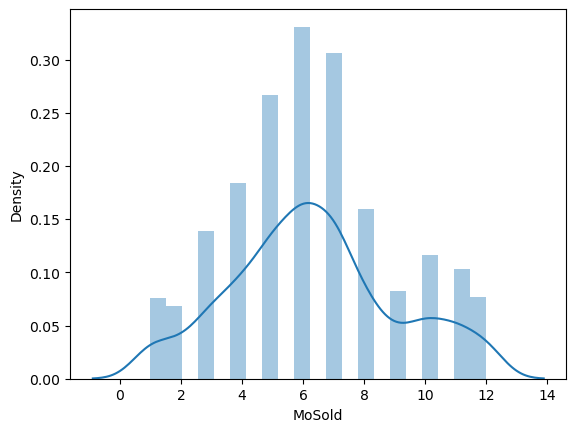

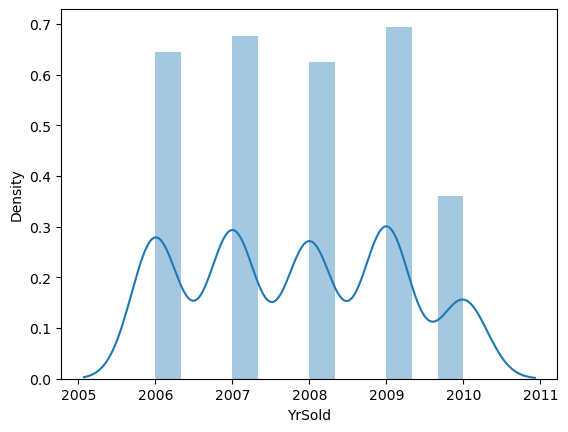

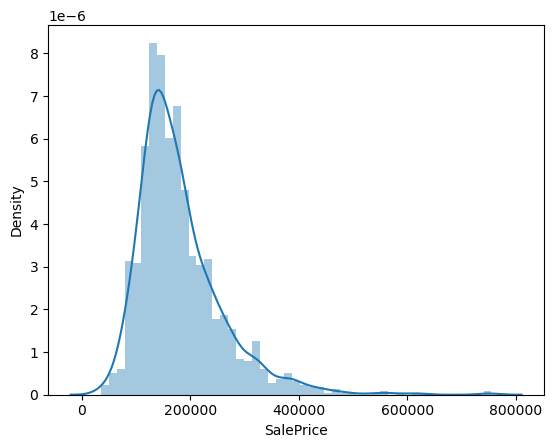

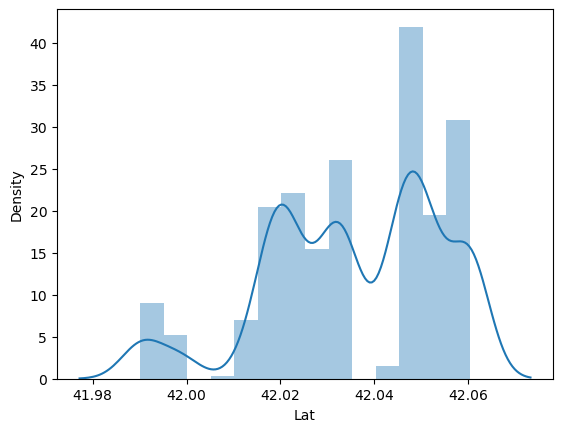

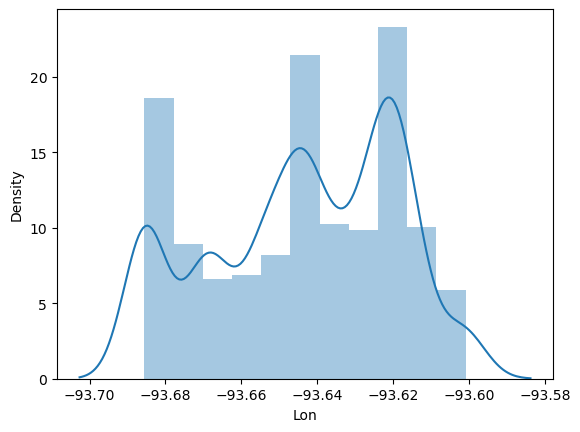

In [17]:
for feature in Numerical_features.columns:
    plotdist(Numerical_features[feature])
    plt.show()

## Distribution of Categorical Features with respect to Sales Price

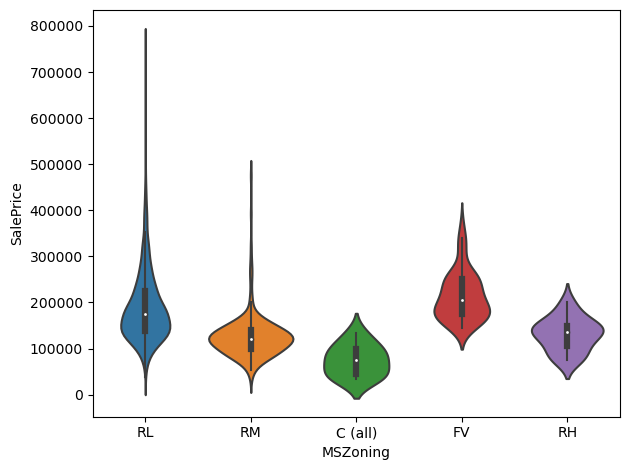

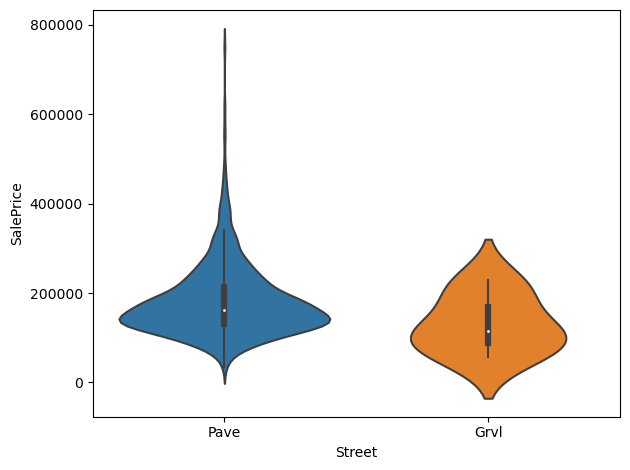

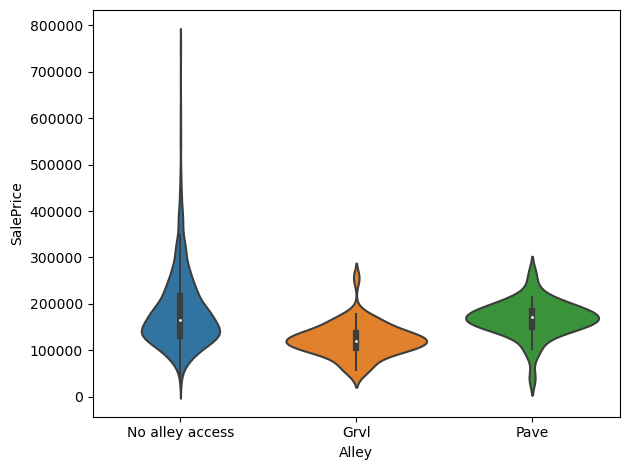

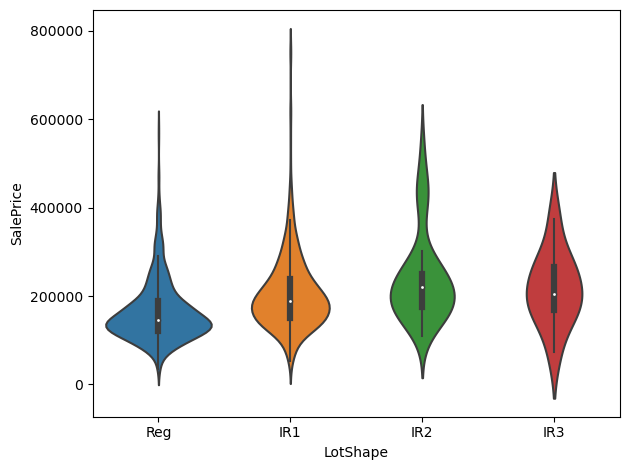

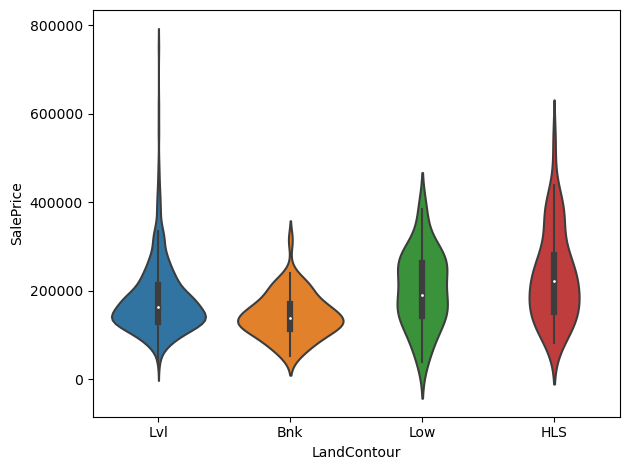

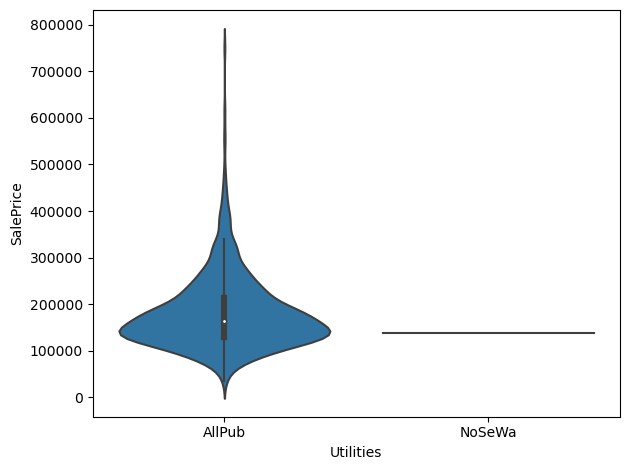

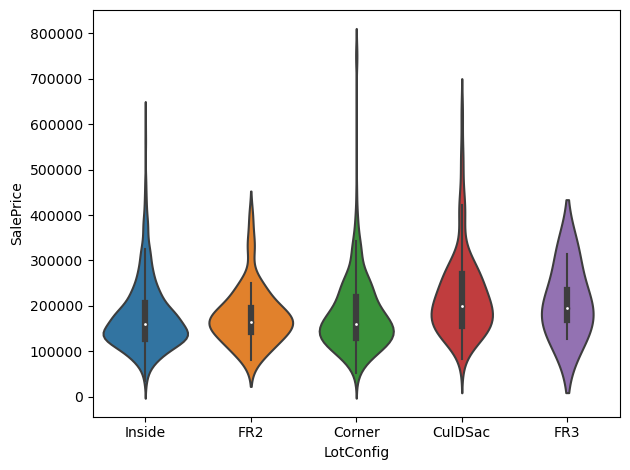

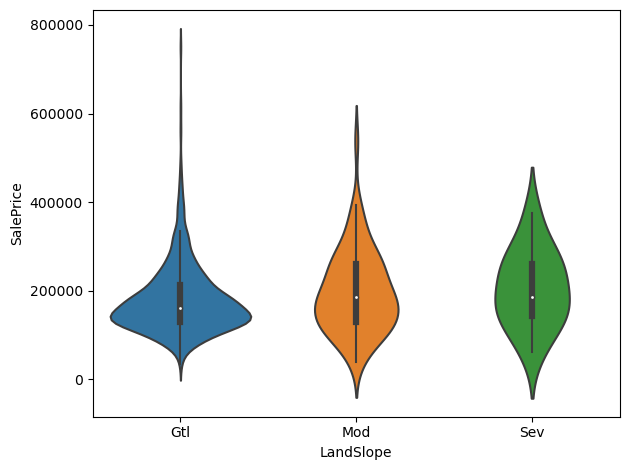

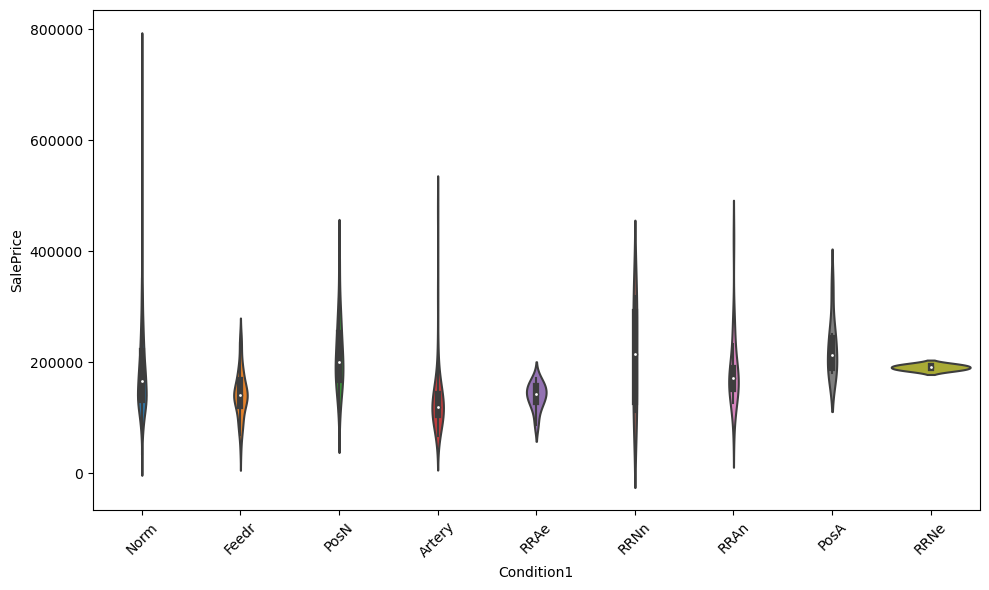

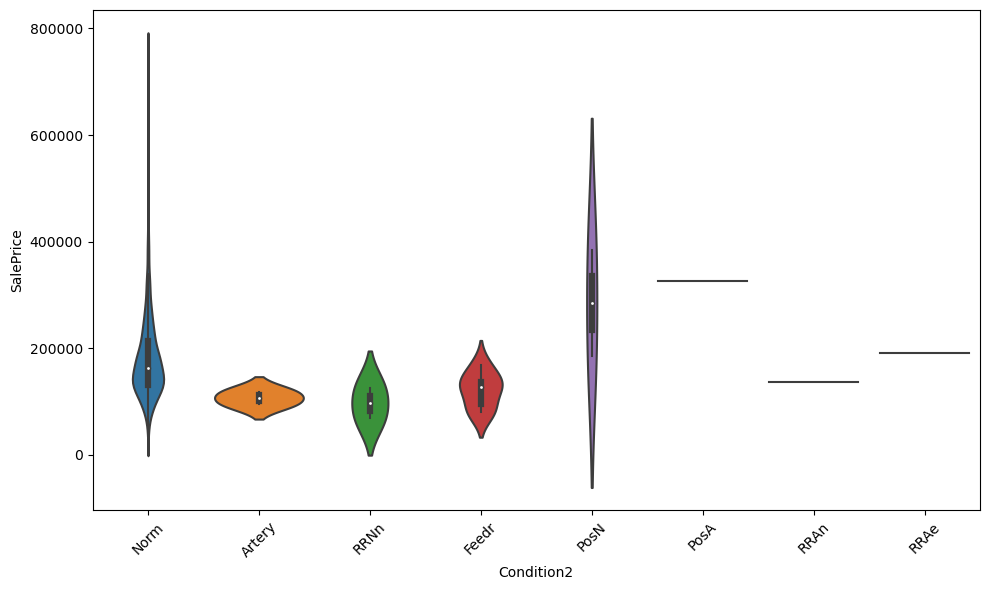

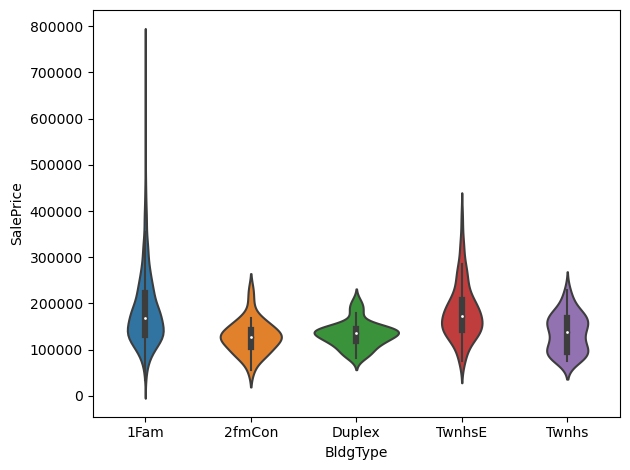

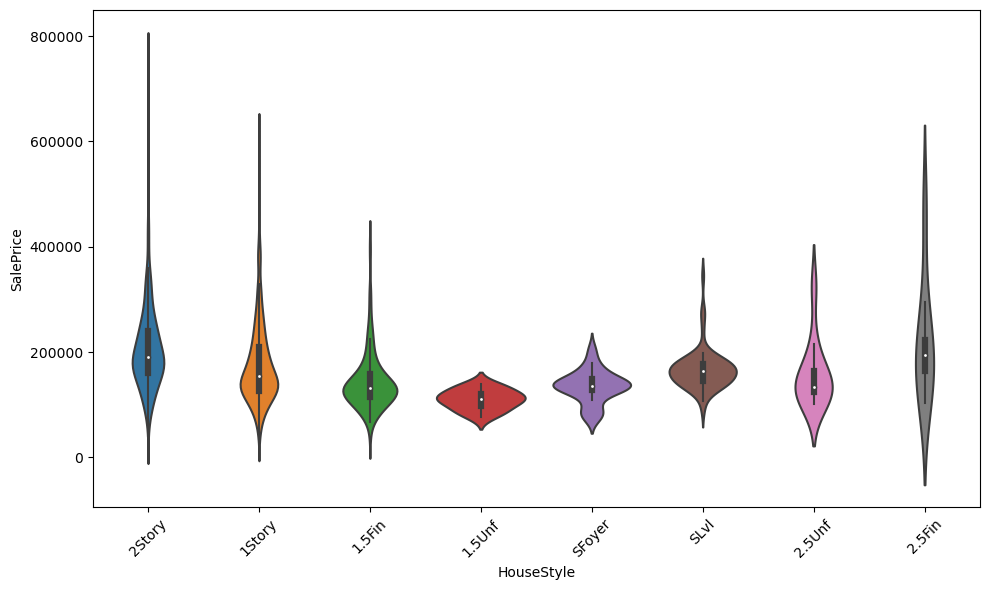

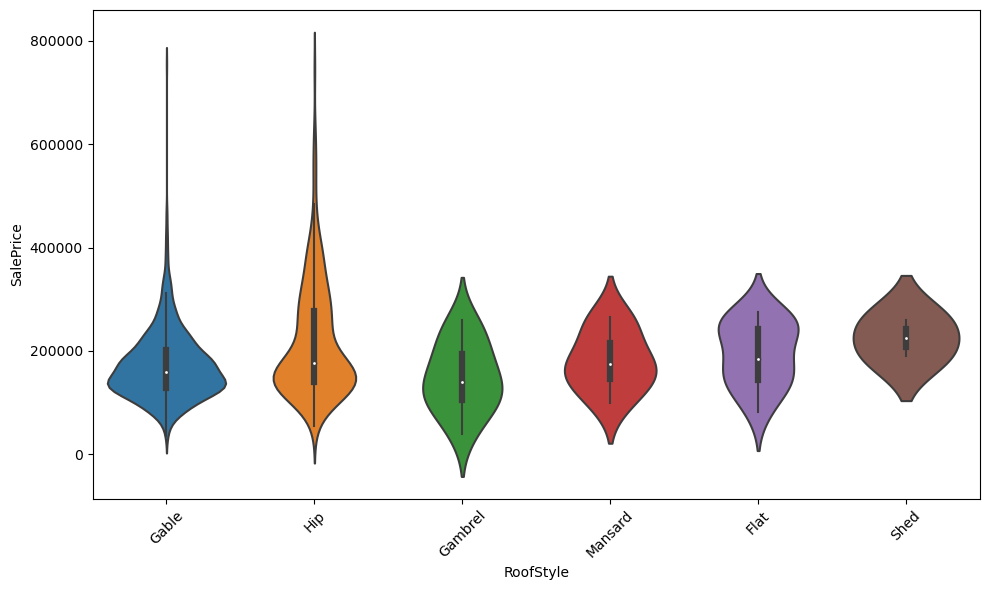

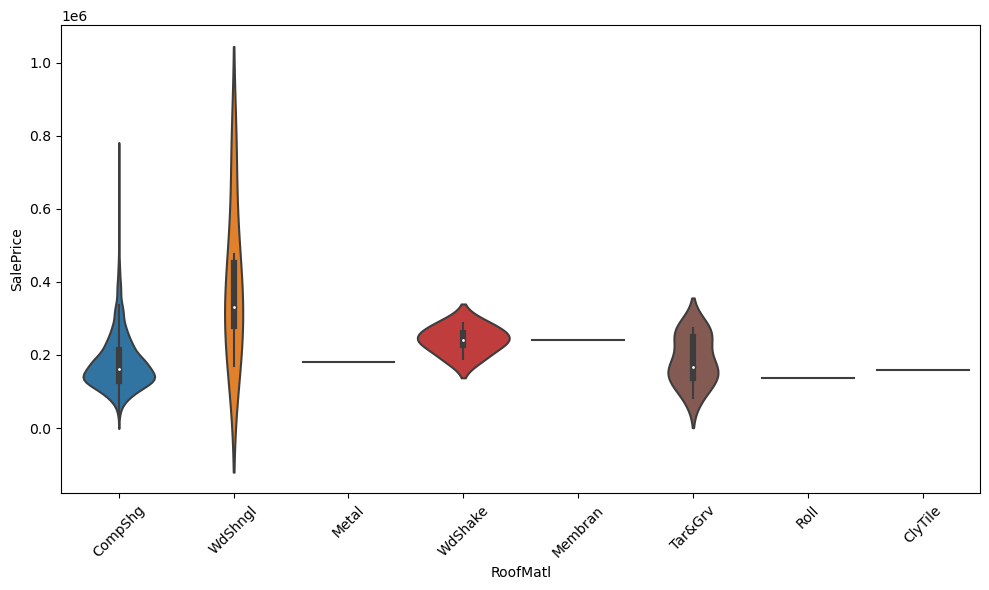

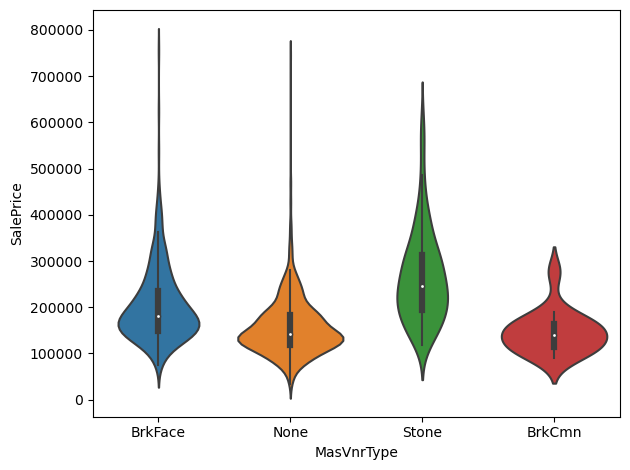

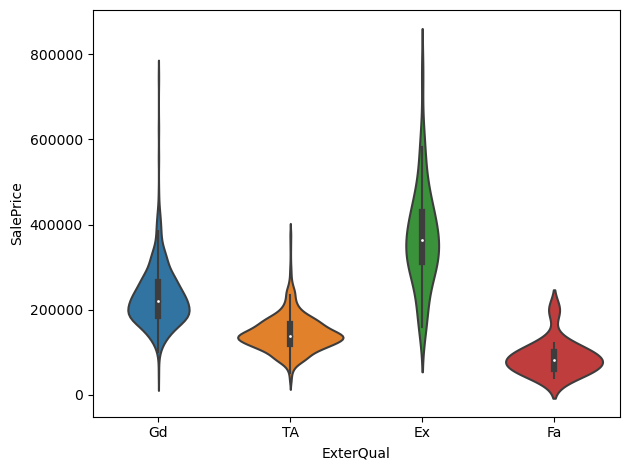

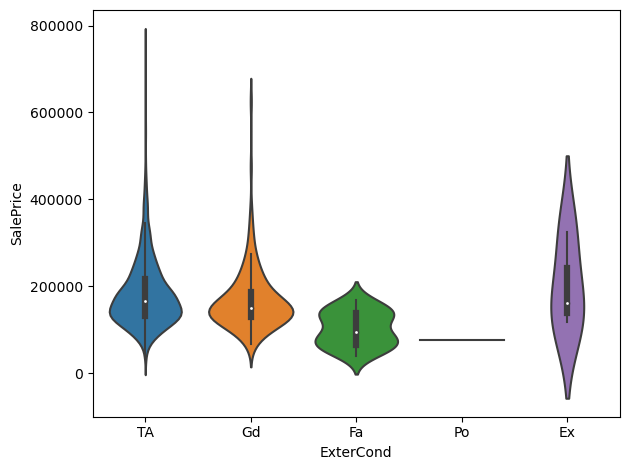

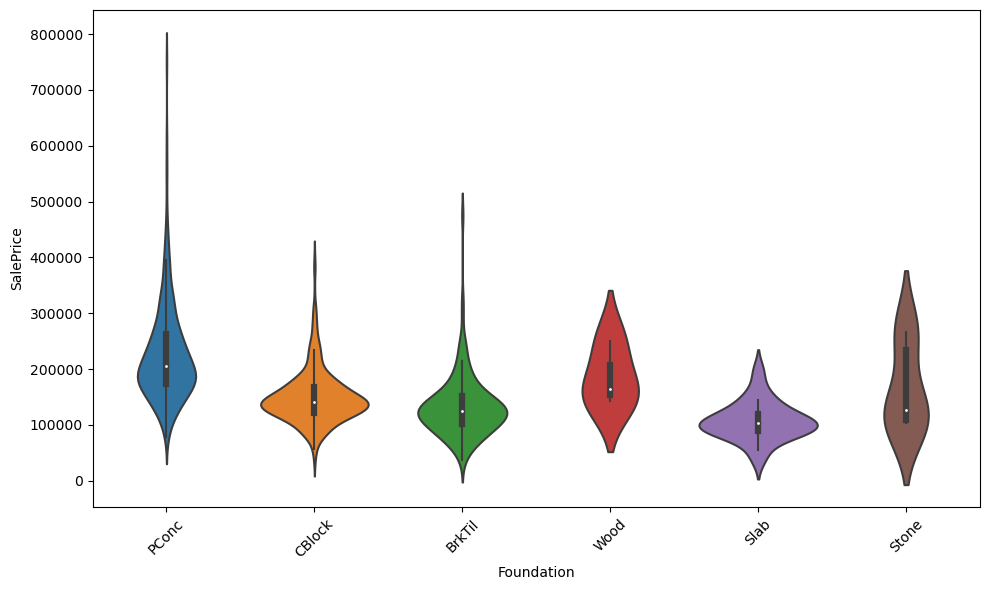

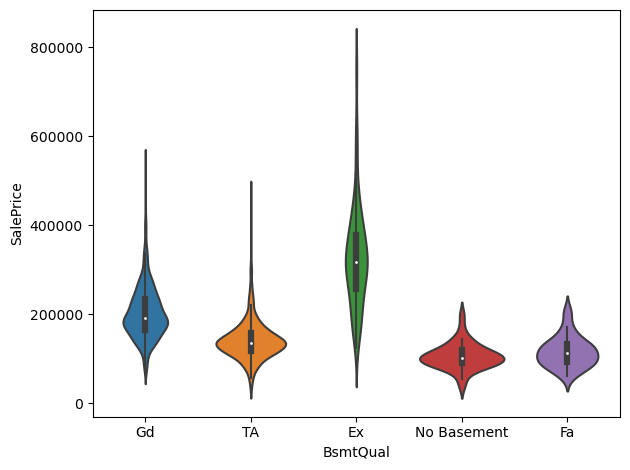

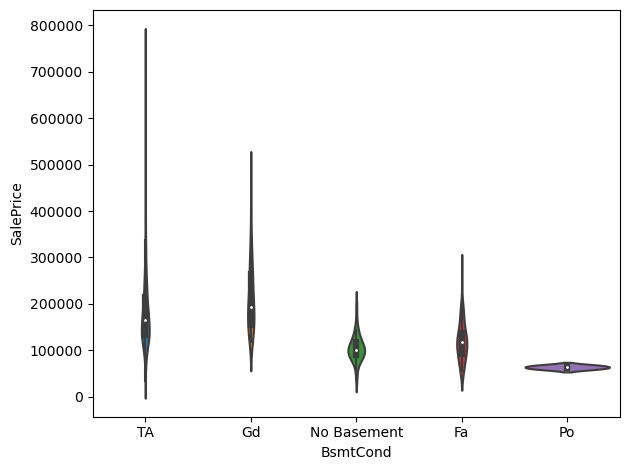

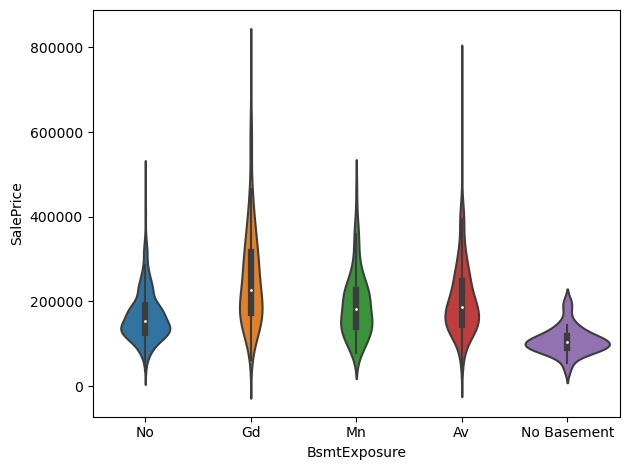

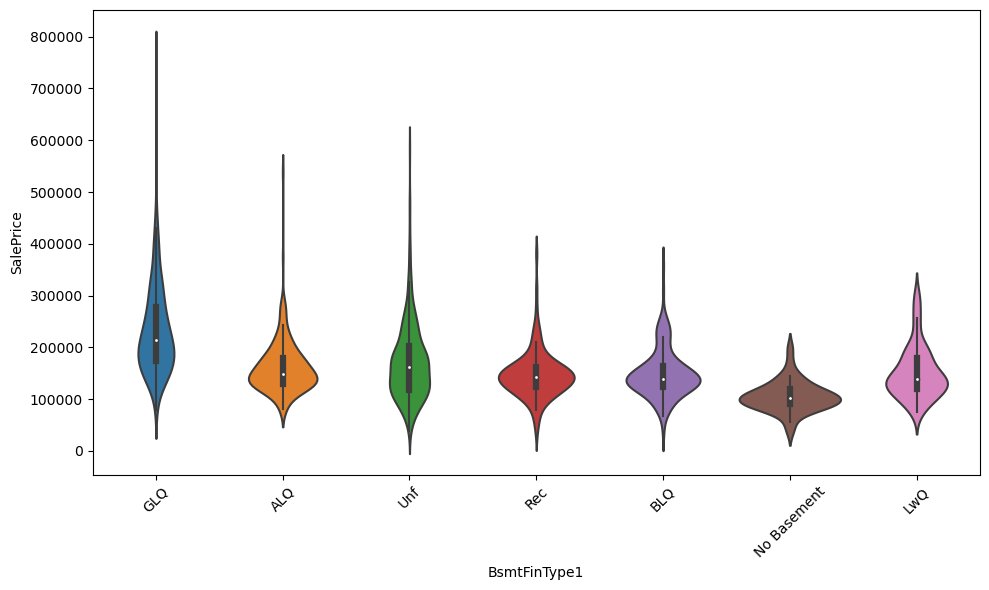

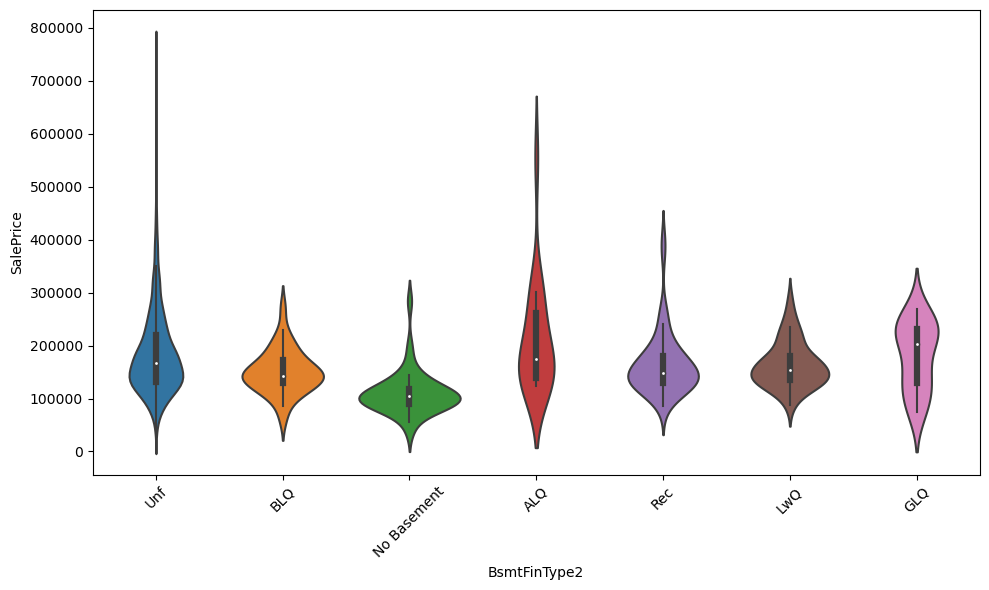

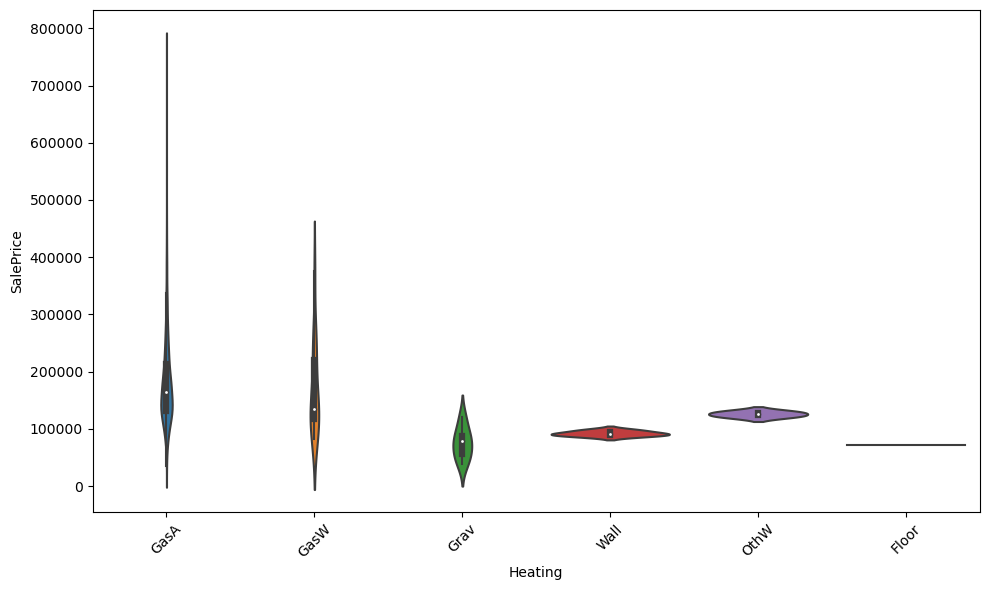

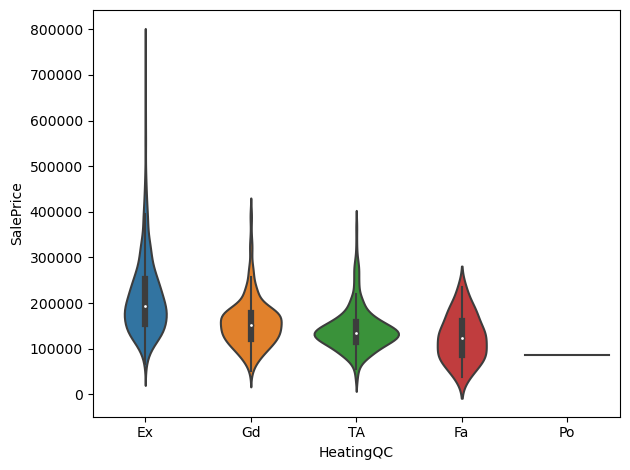

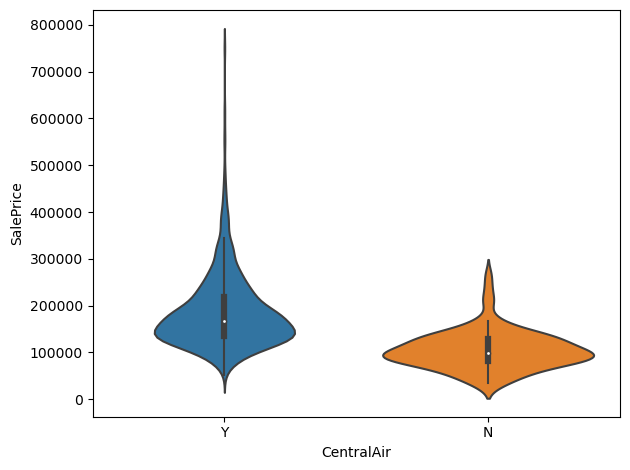

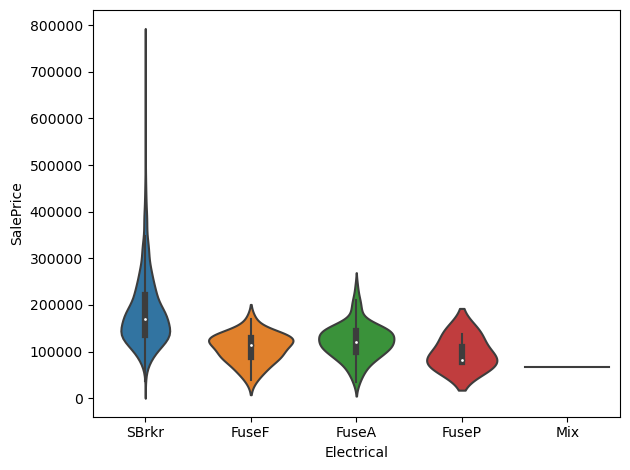

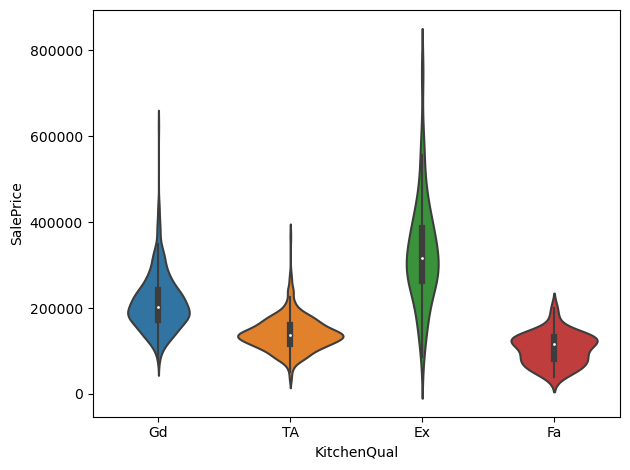

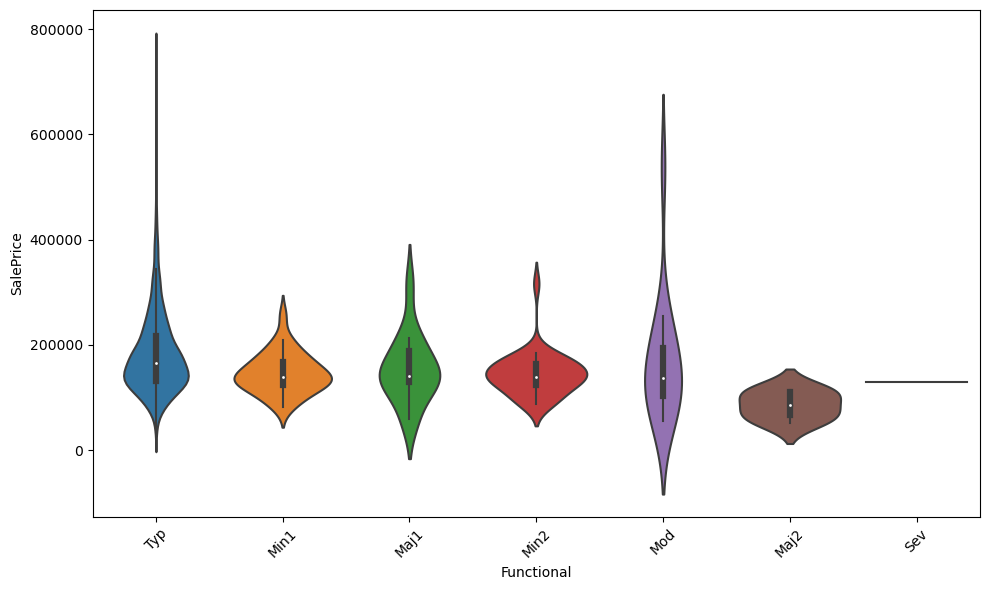

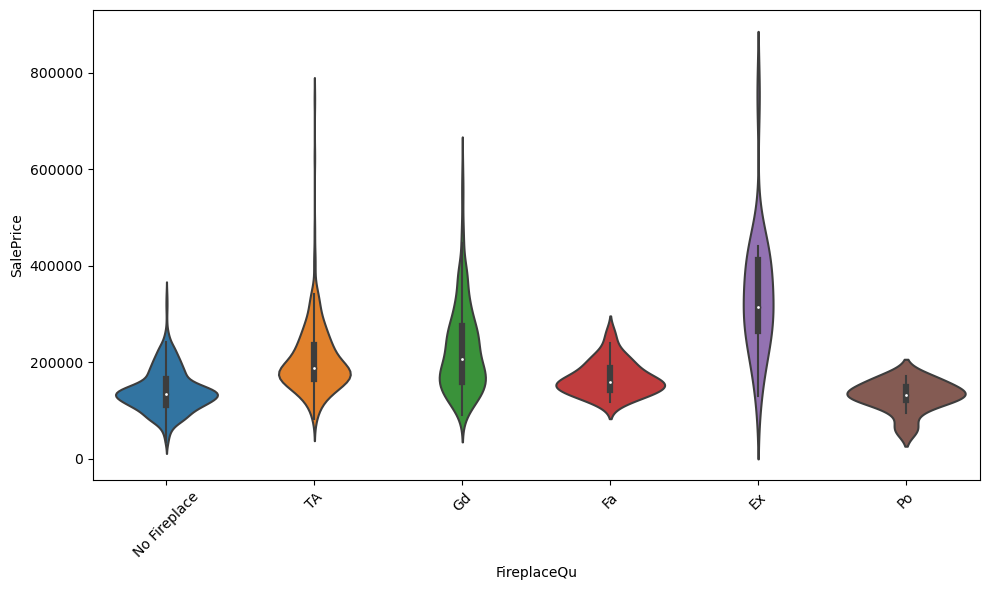

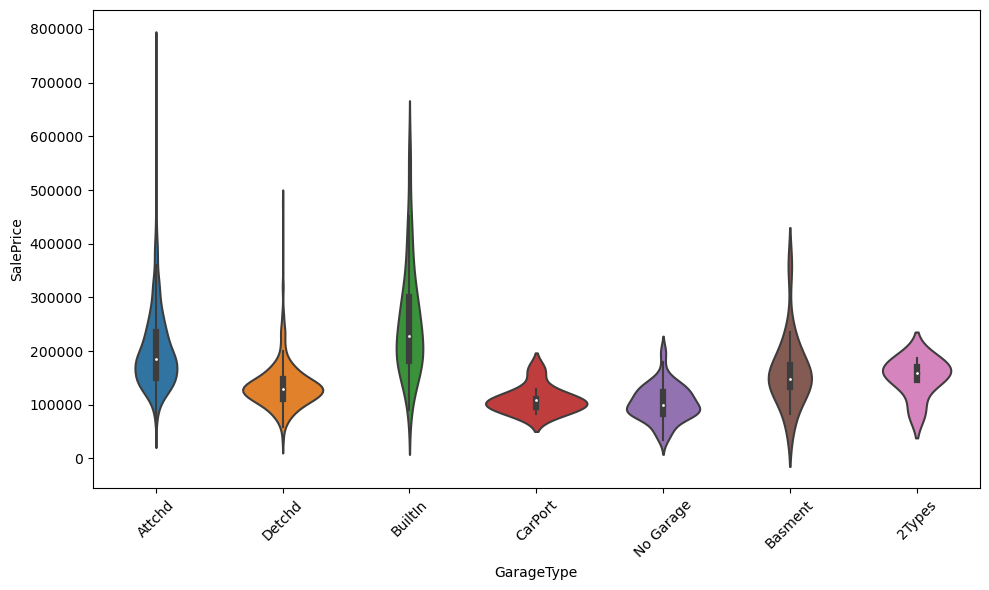

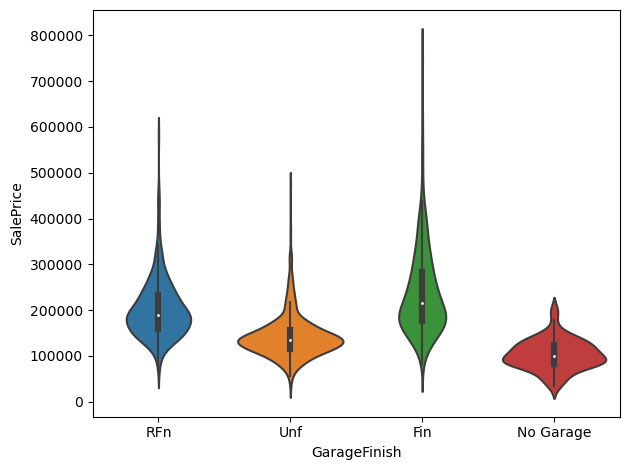

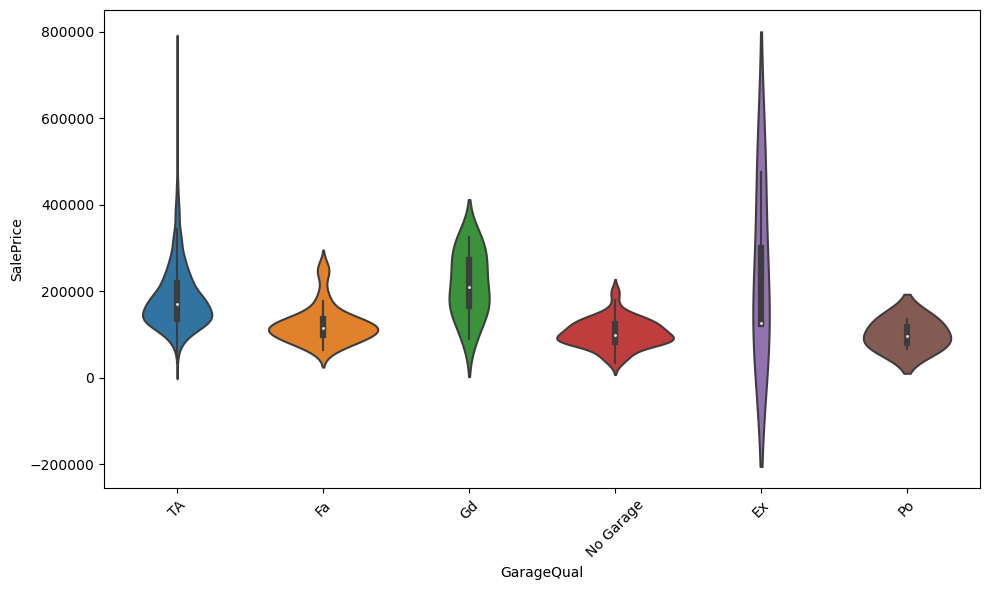

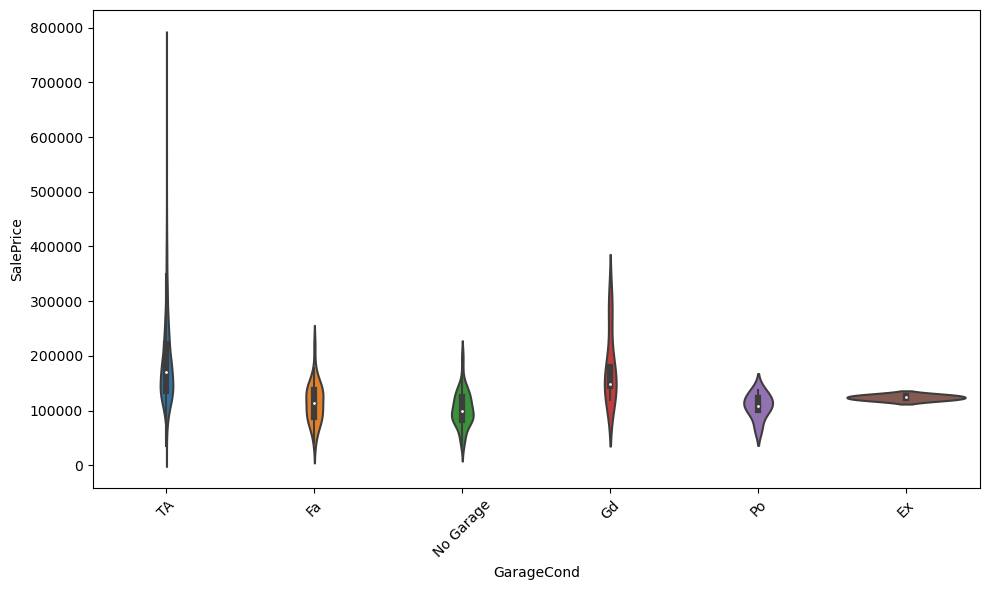

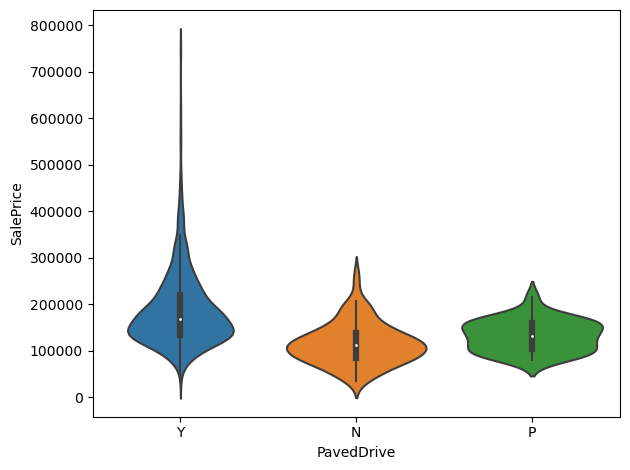

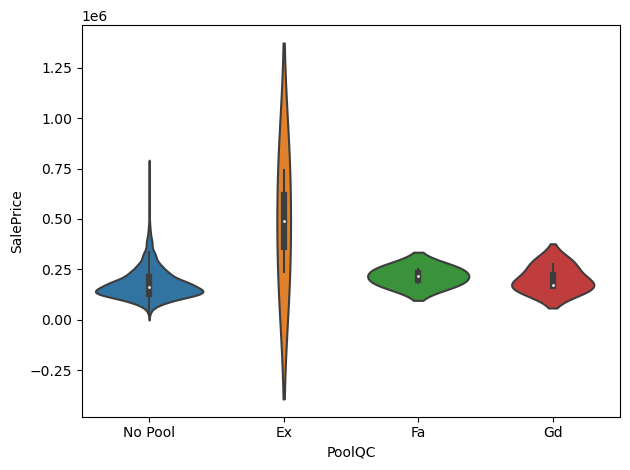

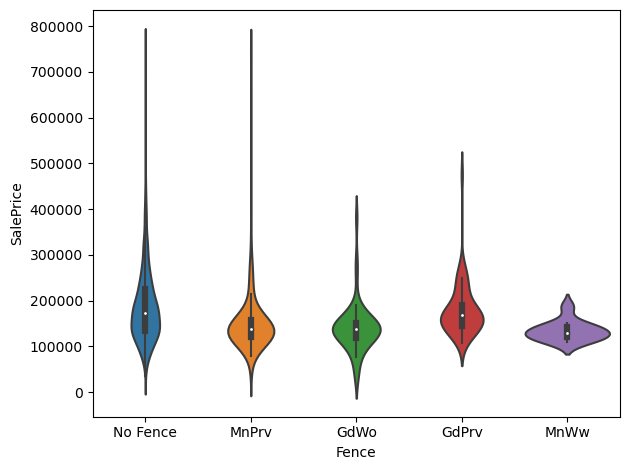

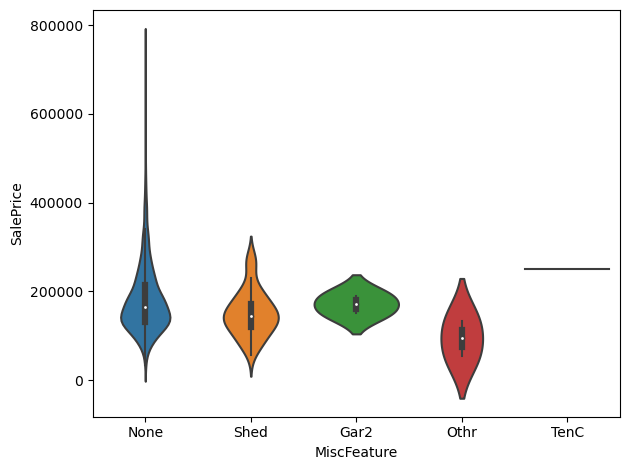

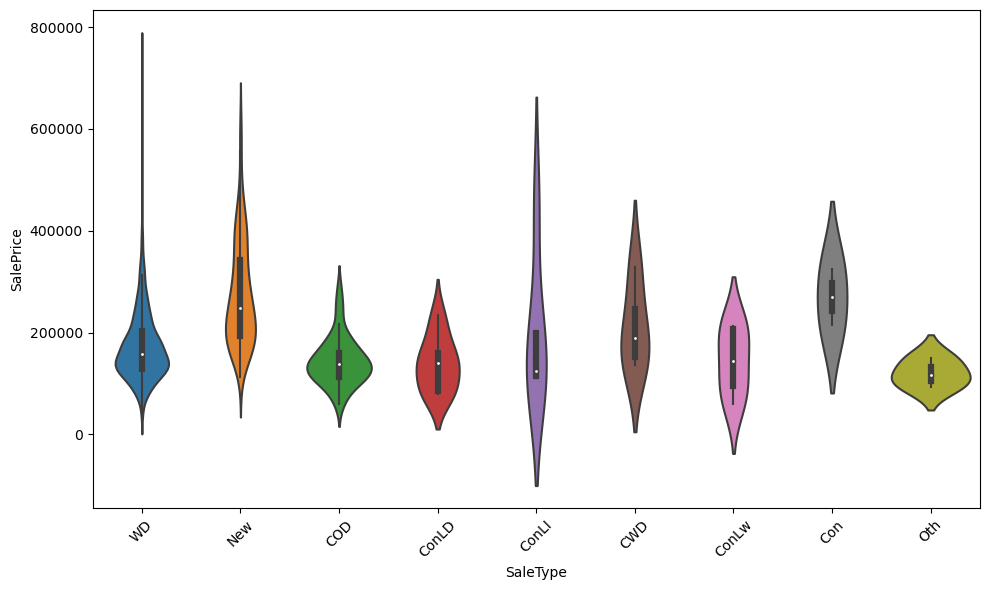

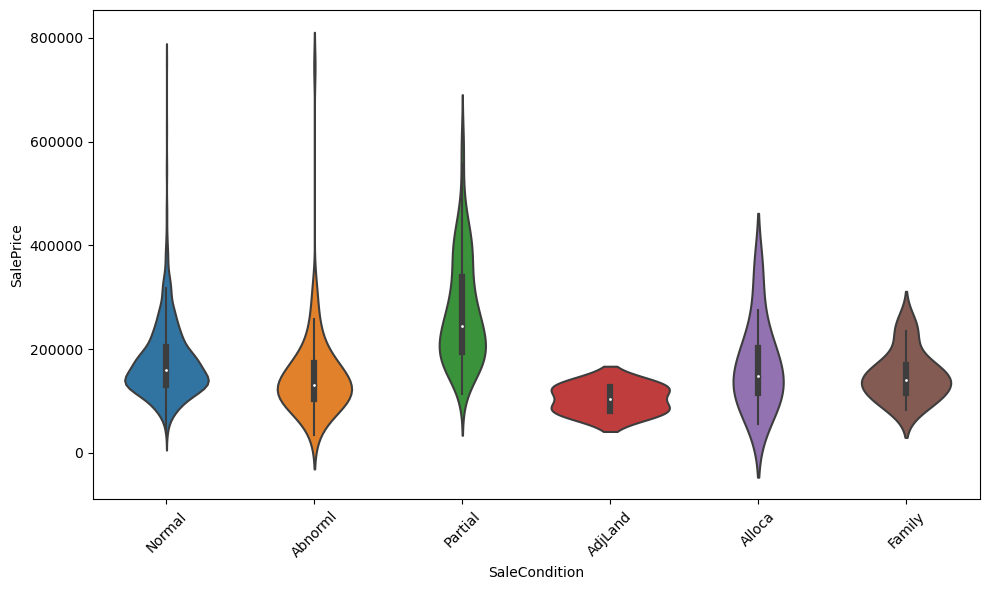

In [18]:
for feature in Categorical_features.columns:
    
    if Categorical_features[feature].nunique() > 12 :
        continue
    if Categorical_features[feature].nunique() > 5 :
        plt.figure(figsize=(10,6))
        plt.xticks(rotation=45)
    sns.violinplot(x=feature,y='SalePrice',data=df_train)
    plt.tight_layout()
    plt.show()

# Data Modelling

In [19]:
X = df_train.drop('SalePrice',axis=1)
y = df_train['SalePrice']

In [20]:
LotFrontageX = X['LotFrontage']
GarageYrBltX = X['GarageYrBlt']

## One Hot Encoding Categorical Variables

In [21]:
ohe = OneHotEncoder(sparse=False,drop="if_binary")
Categorical_Encoded = ohe.fit_transform(Categorical_features.astype(str))

In [22]:
Categorical_Encoded_Frame = pd.DataFrame(Categorical_Encoded, columns= ohe.get_feature_names_out(Categorical_features.columns))
Categorical_Encoded_Frame.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_No alley access,Alley_Pave,LotShape_IR1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
Numerical_features_X = Numerical_features.drop(['SalePrice','LotFrontage','GarageYrBlt'],axis=1)

In [24]:
X = Categorical_Encoded_Frame.join(Numerical_features_X).join(LotFrontageX).join(GarageYrBltX)
Xcolumns = X.columns
X.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_No alley access,Alley_Pave,LotShape_IR1,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Lat,Lon,LotFrontage,GarageYrBlt
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,2,2008,42.018773,-93.685543,65.0,2003.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,5,2007,42.040898,-93.651502,80.0,1976.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0,0,0,0,9,2008,42.018773,-93.685543,68.0,2001.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0,0,0,0,2,2006,42.015189,-93.644250,60.0,1998.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0,0,0,0,12,2008,42.051748,-93.653524,84.0,2000.0


In [25]:
X = KNNImputer(n_neighbors=5).fit_transform(X)

In [26]:
X = pd.DataFrame(X,columns=Xcolumns)
X.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_No alley access,Alley_Pave,LotShape_IR1,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Lat,Lon,LotFrontage,GarageYrBlt
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2008.0,42.018773,-93.685543,65.0,2003.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,2007.0,42.040898,-93.651502,80.0,1976.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,9.0,2008.0,42.018773,-93.685543,68.0,2001.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,2006.0,42.015189,-93.644250,60.0,1998.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,12.0,2008.0,42.051748,-93.653524,84.0,2000.0


## Distribution of dependent variable

<Axes: xlabel='SalePrice', ylabel='Density'>

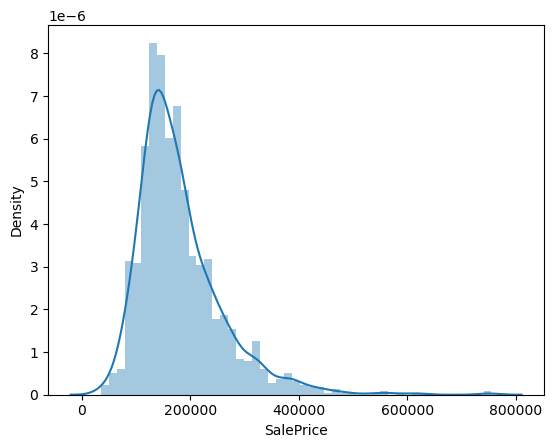

In [27]:
sns.distplot(y)

It is clear from above plot that dependent variable sale price is showing right skewed distribution which need to be handle using log transformation.

In [28]:
y.skew()

1.8828757597682129

In [29]:
y_log = np.log(y)

In [30]:
y_log.skew()

0.12133506220520406

<Axes: xlabel='SalePrice', ylabel='Density'>

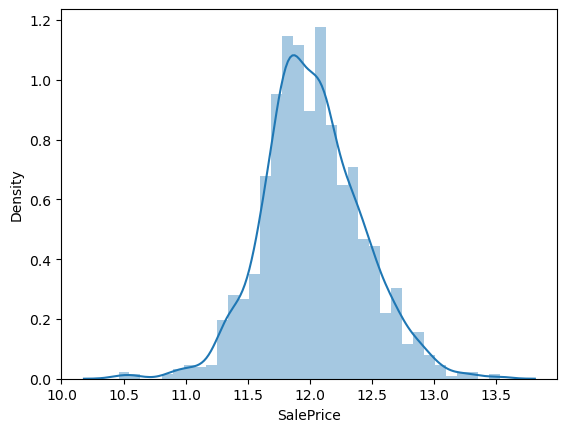

In [31]:
sns.distplot(y_log)

## Train/Test Split

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)

In [33]:
print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("y_train Shape: ",y_train.shape)
print("y_test Shape: ",y_test.shape)

X_train Shape:  (1022, 301)
X_test Shape:  (438, 301)
y_train Shape:  (1022,)
y_test Shape:  (438,)


## Standardization

In [34]:

xStandardScaler = StandardScaler()
yStandardScaler = StandardScaler()

In [35]:
X_train = xStandardScaler.fit_transform(X_train)
X_test = xStandardScaler.transform(X_test)

In [36]:
y_train = yStandardScaler.fit_transform(y_train.ravel().reshape(-1, 1))
y_test = yStandardScaler.transform(y_test.ravel().reshape(-1, 1))

## Model Comparision Storage

In [37]:
ModelCompList = list()

# Lasso Linear Regression

In [38]:
alphas = np.linspace(0,.1,num=21)
lgLasso = LassoCV(cv=10,alphas=alphas)
lgLasso.fit(X_train,y_train)

LassoCV(alphas=array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  ]),
        cv=10)

## Alpha

In [39]:
# print the intercept
print(lgLasso.alpha_)

0.02


## Top 10 Feature Importance ( Positive and Negative Role )

Text(0.5, 1.0, 'Top 10 Positive Features')

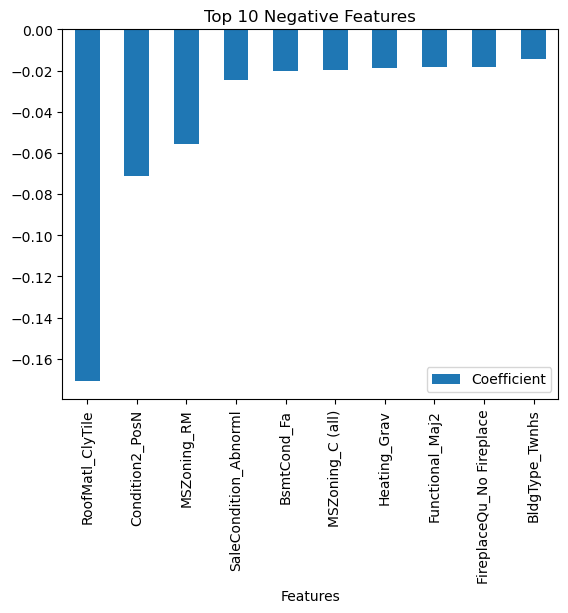

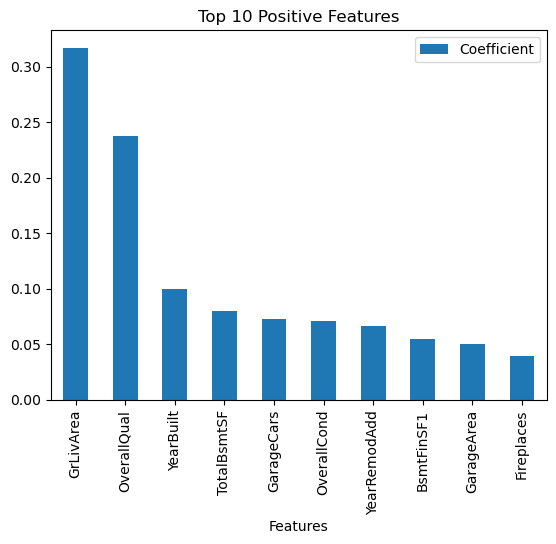

In [40]:
coeff_df = pd.DataFrame(lgLasso.coef_.T,X.columns,columns=['Coefficient'])
coeff_df.sort_values(by='Coefficient').head(10).plot(kind='bar')
plt.xlabel('Features')
plt.title('Top 10 Negative Features')

coeff_df.sort_values(by='Coefficient',ascending=False).head(10).plot(kind='bar')
plt.xlabel('Features')
plt.title('Top 10 Positive Features')


## Prediction from Linear Model

In [41]:
predictionsLinear = lgLasso.predict(X_test)

In [46]:
predictionsLinear = predictionsLinear.reshape(-1,1)

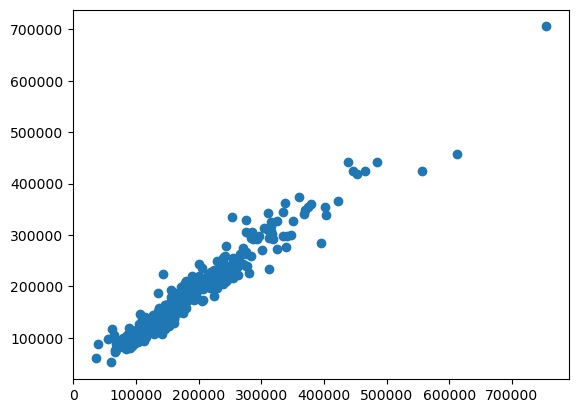

In [47]:
plt.scatter(np.exp(yStandardScaler.inverse_transform(y_test)),np.exp(yStandardScaler.inverse_transform(predictionsLinear)))

## Residual Plot

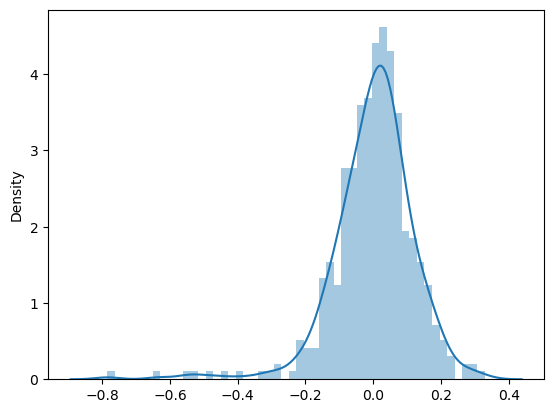

In [48]:
sns.distplot((yStandardScaler.inverse_transform(y_test)-yStandardScaler.inverse_transform(predictionsLinear)),bins=50);

## Evaluation

In [49]:
def evaluateModel(name,y_test,Predictions):
    modelComp = dict()
    modelComp['Name'] = name
    modelComp['MAE'] = metrics.mean_absolute_error(np.exp(yStandardScaler.inverse_transform(y_test)),
                                                   np.exp(yStandardScaler.inverse_transform(Predictions)))
    modelComp['MSE'] = metrics.mean_squared_error(np.exp(yStandardScaler.inverse_transform(y_test)),
                                                  np.exp(yStandardScaler.inverse_transform(Predictions)))
    modelComp['RMSE'] = np.sqrt(metrics.mean_squared_error(np.exp(yStandardScaler.inverse_transform(y_test)),
                                                           np.exp(yStandardScaler.inverse_transform(Predictions))))
    
    print('MAE:', modelComp['MAE'])
    print('MSE:', modelComp['MSE'])
    print('RMSE:', modelComp['RMSE'])
    
    ModelCompList.append(modelComp)

In [50]:
evaluateModel('Lasso',y_test,predictionsLinear)

MAE: 14607.57917846508
MSE: 481091669.19243914
RMSE: 21933.801977597024


# Ridge Linear Regression

In [51]:
alphas = np.linspace(0,20,num=21)
lgRidge = RidgeCV(cv=10,alphas=alphas)
lgRidge.fit(X_train,y_train)

ValueError: alphas[0] == 0.0, must be > 0.0.

## Alpha

In [ ]:
# print the intercept
print(lgRidge.alpha_)

## Top 10 Feature Importance ( Positive and Negative Role )

In [ ]:
coeff_df = pd.DataFrame(lgRidge.coef_.T,X.columns,columns=['Coefficient'])
coeff_df.sort_values(by='Coefficient').head(10).plot(kind='bar')
plt.xlabel('Features')
plt.title('Top 10 Negative Features')

coeff_df.sort_values(by='Coefficient',ascending=False).head(10).plot(kind='bar')
plt.xlabel('Features')
plt.title('Top 10 Positive Features')


## Prediction from Linear Model

In [ ]:
predictionsLinear = lgRidge.predict(X_test)

In [ ]:
plt.scatter(np.exp(yStandardScaler.inverse_transform(y_test)),np.exp(yStandardScaler.inverse_transform(predictionsLinear)))

## Residual Plot

In [ ]:
sns.distplot((yStandardScaler.inverse_transform(y_test)-yStandardScaler.inverse_transform(predictionsLinear)),bins=50);

## Evaluation

In [ ]:
evaluateModel('Ridge',y_test,predictionsLinear)

# Elastic Net Linear Regression

In [ ]:
alphas = np.linspace(0,10,num=21)
l1_ratio = np.linspace(0,1,num=21)
lgNet = ElasticNetCV(cv=10,alphas=alphas,l1_ratio=l1_ratio)
lgNet.fit(X_train,y_train)

## Alpha

In [ ]:
# print the intercept
print(lgNet.alpha_)
print(lgNet.l1_ratio_)

## Top 10 Feature Importance ( Positive and Negative Role )

In [ ]:
coeff_df = pd.DataFrame(lgNet.coef_.T,X.columns,columns=['Coefficient'])
coeff_df.sort_values(by='Coefficient').head(10).plot(kind='bar')
plt.xlabel('Features')
plt.title('Top 10 Negative Features')

coeff_df.sort_values(by='Coefficient',ascending=False).head(10).plot(kind='bar')
plt.xlabel('Features')
plt.title('Top 10 Positive Features')


## Prediction from Linear Model

In [ ]:
predictionsLinear = lgNet.predict(X_test)

In [ ]:
plt.scatter(np.exp(yStandardScaler.inverse_transform(y_test)),np.exp(yStandardScaler.inverse_transform(predictionsLinear)))

## Residual Plot

In [ ]:
sns.distplot((yStandardScaler.inverse_transform(y_test)-yStandardScaler.inverse_transform(predictionsLinear)),bins=50);

## Evaluation

In [ ]:
evaluateModel('Elastic Net',y_test,predictionsLinear)

# Random Forest Regressor

In [ ]:
rfr = RandomForestRegressor(n_estimators=2500)
parameters = {'min_samples_split': [2],
              'max_depth': [8],
              'min_samples_leaf' :[2],
              'max_samples': [.7]}


In [ ]:
rfr_grid = GridSearchCV(rfr,
                        parameters,
                        cv = 2)

In [ ]:
rfr_grid.fit(X_train,y_train)

## Best Score and Params

In [ ]:
print(rfr_grid.best_score_)
print(rfr_grid.best_params_)

## Feature Importance

In [ ]:
coeff_df = pd.DataFrame(rfr_grid.best_estimator_.feature_importances_,X.columns,columns=['Importances'])

coeff_df.sort_values(by='Importances',ascending=False).head(10).plot(kind='bar')
plt.xlabel('Features')
plt.title('Top 10 Positive Features')


## Predictions

In [ ]:
predictionsForest = rfr_grid.best_estimator_.predict(X_test)

In [ ]:
plt.scatter(yStandardScaler.inverse_transform(y_test),yStandardScaler.inverse_transform(predictionsForest))

## Residual Plot

In [ ]:
sns.distplot((np.exp(yStandardScaler.inverse_transform(y_test))-np.exp(yStandardScaler.inverse_transform(predictionsForest))),bins=50);

## Evaluation

In [ ]:
evaluateModel('Random Forest',y_test,predictionsForest)

We have seen that to make our machine model work better in terms of error  we have to follow normal distribution phenomenon to make machine model results reliable but that's not the case with neural network. Neural network works on converges, pattern finding doesnt depend on normal distribution formula either we can use it or we can drop it .

# XG Boost Regressor

In [ ]:
xgb = XGBRegressor()
parameters = {'objective':['reg:squarederror'],
            'learning_rate': [.1],
              'max_depth': [3],
              'min_child_weight': [2],
              'subsample': [0.7],
              'colsample_bytree': [.7],
              'colsample_bylevel':[.7],
              'alpha' : [.05],
              'lambda' : [.3],
              'n_estimators': [2500]}


In [ ]:
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2)
xgb_grid.fit(X_train,
         y_train)

## Best Score and Parameters

In [ ]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

## Top 10 Feature Importance ( Positive and Negative Role )

In [ ]:
coeff_df = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_,X.columns,columns=['Coefficient'])

coeff_df.sort_values(by='Coefficient',ascending=False).head(10).plot(kind='bar')
plt.xlabel('Features')
plt.title('Top 10 Positive Features')


## Prediction from Linear Model

In [ ]:
predictionsLinear = xgb_grid.predict(X_test)

In [ ]:
plt.scatter(np.exp(yStandardScaler.inverse_transform(y_test)),np.exp(yStandardScaler.inverse_transform(predictionsLinear)))

## Residual Plot

In [ ]:
sns.distplot((yStandardScaler.inverse_transform(y_test)-yStandardScaler.inverse_transform(predictionsLinear)),bins=50);

## Evaluation

In [ ]:
evaluateModel('XG Boost',y_test,predictionsLinear)

# Light GBM Regressor

In [ ]:
xgb = LGBMRegressor()
parameters = {'learning_rate': [.1],
              'max_depth': [6],
              'min_child_weight': [1],
              'subsample': [0.7],
              'colsample_bytree': [.7],
              'colsample_bylevel': [.7],
              'reg_alpha' : [.1],
              'reg_lambda' : [.3],
              'n_estimators': [12500]}


In [ ]:
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2)
xgb_grid.fit(X_train,
         y_train)

## Best Score and Parameters

In [ ]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

## Top 10 Feature Importance ( Positive and Negative Role )

In [ ]:
coeff_df = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_,X.columns,columns=['Coefficient'])

coeff_df.sort_values(by='Coefficient',ascending=False).head(10).plot(kind='bar')
plt.xlabel('Features')
plt.title('Top 10 Positive Features')


## Prediction from Linear Model

In [ ]:
predictionsLinear = xgb_grid.predict(X_test)

In [ ]:
plt.scatter(np.exp(yStandardScaler.inverse_transform(y_test)),np.exp(yStandardScaler.inverse_transform(predictionsLinear)))

## Residual Plot

In [ ]:
sns.distplot((yStandardScaler.inverse_transform(y_test)-yStandardScaler.inverse_transform(predictionsLinear)),bins=50);

## Evaluation

In [ ]:
evaluateModel('Light GBM',y_test,predictionsLinear)

# Neural Network

## Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print("X_train Shape: ",X_train_nn.shape)
print("X_test Shape: ",X_test_nn.shape)
print("y_train Shape: ",y_train_nn.shape)
print("y_test Shape: ",y_test_nn.shape)

In [ ]:

xStandardScaler = StandardScaler()
yStandardScaler = StandardScaler()

X_train_nn = xStandardScaler.fit_transform(X_train_nn)
X_test_nn = xStandardScaler.transform(X_test_nn)

y_train_nn = yStandardScaler.fit_transform(y_train_nn.ravel().reshape(-1, 1))
y_test_nn= yStandardScaler.transform(y_test_nn.ravel().reshape(-1, 1))

## Defining model

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim=301))
model.add(LeakyReLU(alpha=.1))
model.add(Dropout(.1))
model.add(Dense(192, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.summary()

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse'])

In [ ]:
mcp = ModelCheckpoint(
    'model.h5',
    monitor="val_mse",
    verbose=2,
    save_best_only=True,
    mode="min"
)

In [ ]:
history = model.fit(X_train_nn,y_train_nn,epochs=100,batch_size=32,callbacks=mcp,validation_data=(X_test_nn,y_test_nn))

## Performance

In [ ]:
# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

In [ ]:
model = load_model('model.h5')

In [ ]:
predictionsNeural = model.predict(X_test_nn)

## Evaluation

In [ ]:
modelComp = dict()
modelComp['Name'] = 'Neural Network'
modelComp['MAE'] = metrics.mean_absolute_error(yStandardScaler.inverse_transform(y_test_nn),
                                               yStandardScaler.inverse_transform(predictionsNeural))
modelComp['MSE'] = metrics.mean_squared_error(yStandardScaler.inverse_transform(y_test_nn),
                                              yStandardScaler.inverse_transform(predictionsNeural))
modelComp['RMSE'] = np.sqrt(metrics.mean_squared_error(yStandardScaler.inverse_transform(y_test_nn),
                                                       yStandardScaler.inverse_transform(predictionsNeural)))

print('MAE:', modelComp['MAE'])
print('MSE:', modelComp['MSE'])
print('RMSE:', modelComp['RMSE'])

ModelCompList.append(modelComp)

# Model Comparision

In [ ]:
df_models = pd.DataFrame(ModelCompList)
df_models.head()

In [ ]:
for i in df_models.columns[1:]:
    sns.barplot(x='Name',y=i,data=df_models)
    plt.xlabel('Model')
    plt.xticks(rotation=-45)
    plt.show()

## Data Preparation of Test Data

In [ ]:
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
df_test.head()

In [ ]:
IdTest = df_test['Id']
df_test.drop('Id',axis=1,inplace=True)

In [ ]:
visualNA(df_test)

In [ ]:
handleNA(df_test)

In [ ]:
visualNA(df_test)

Data Cleaning and transformation of test data is done using proper analysis with respect to other co factor variables.

In [ ]:
df_test.loc[(df_test['MSZoning'].isnull()) & (df_test['MSSubClass'].astype(int)<70),'MSZoning'] = 'RL'
df_test.loc[(df_test['MSZoning'].isnull()) & (df_test['MSSubClass'].astype(int)>=70),'MSZoning'] = 'RM'

In [ ]:
df_test.loc[df_test['Utilities'].isnull(),'Utilities'] = 'AllPub'

In [ ]:
df_test.loc[df_test['Exterior1st'].isnull(),'Exterior1st'] = 'Wd Sdng'

In [ ]:
df_test.loc[df_test['Exterior2nd'].isnull(),'Exterior2nd'] = 'Wd Sdng'

In [ ]:
df_test.loc[df_test['BsmtFinSF1'].isnull(),'BsmtFinSF1'] = 180

In [ ]:
df_test.loc[df_test['BsmtFinSF2'].isnull(),'BsmtFinSF2'] = 374

In [ ]:
df_test.loc[df_test['BsmtUnfSF'].isnull(),'BsmtUnfSF'] = 340

In [ ]:
df_test.loc[df_test['TotalBsmtSF'].isnull(),'TotalBsmtSF'] = 894

In [ ]:
df_test.loc[(df_test['BsmtFullBath'].isnull()) & (df_test['FullBath']==1),'BsmtFullBath'] = 0
df_test.loc[(df_test['BsmtFullBath'].isnull()) & (df_test['FullBath']==3),'BsmtFullBath'] = 1

In [ ]:
df_test.loc[df_test['BsmtHalfBath'].isnull(),'BsmtHalfBath'] = 0

In [ ]:
df_test.loc[df_test['KitchenQual'].isnull(),'KitchenQual'] = 'TA'

In [ ]:
df_test.loc[(df_test['Functional'].isnull()) & (df_train['ScreenPorch']<1), 'Functional'] = 'Typ'
df_test.loc[(df_test['Functional'].isnull()) & (df_train['ScreenPorch']>1) , 'Functional'] = 'Mod'

In [ ]:
df_test.loc[df_test['GarageCars'].isnull(),'GarageCars']= 2

In [ ]:
df_test.loc[df_test['GarageArea'].isnull(),'GarageArea']= 324

In [ ]:
df_test.loc[df_test['SaleType'].isnull(),'SaleType'] = 'WD'

In [ ]:
visualNA(df_test)

In [ ]:
df_test['Lat'] = df_test['Neighborhood'].map(lambda neighbor: dict_neighbor[neighbor]['lat'])
df_test['Lon'] = df_test['Neighborhood'].map(lambda neighbor: dict_neighbor[neighbor]['lon'])

In [ ]:
Categorical_features_test = df_test.select_dtypes(include=['object'])
Numerical_features_test = df_test.select_dtypes(exclude=['object'])

In [ ]:
Categorical_Encoded_test = ohe.transform(Categorical_features_test)

Categorical_Encoded_Frame_test = pd.DataFrame(Categorical_Encoded_test, columns= ohe.get_feature_names(Categorical_features_test.columns))
Categorical_Encoded_Frame_test.head()

In [ ]:
LotFrontageTestX = Numerical_features_test['LotFrontage']
GarageYrBltTestX = Numerical_features_test['GarageYrBlt']
Numerical_features_test.drop(['LotFrontage','GarageYrBlt'],axis=1,inplace=True)

In [ ]:
X_test_Full = Categorical_Encoded_Frame_test.join(Numerical_features_test).join(LotFrontageTestX).join(GarageYrBltTestX)
X_testcolumns = X_test_Full.columns
X_test_Full.head()

In [ ]:
X_test_Full = KNNImputer(n_neighbors=5).fit_transform(X_test_Full)

In [ ]:
X_test_Frame = pd.DataFrame(X_test_Full,columns=X_testcolumns)
X_test_Frame.head()

# Target Model Creation

In [ ]:
Xtest = StandardScaler()
Ytest = StandardScaler()

X_Full = Xtest.fit_transform(X)
y_Full = Ytest.fit_transform(y_log.ravel().reshape(-1,1))

## Lasso

In [ ]:
lgLassoFinal = LassoCV(cv=5,alphas =[.02])
lgLassoFinal.fit(X_Full,y_Full)

In [ ]:
X_test_Frame = Xtest.transform(X_test_Frame)

In [ ]:
ypredLasso = lgLassoFinal.predict(X_test_Frame)

## Ridge

In [ ]:
lgRidgeFinal = RidgeCV(cv=5,alphas =[20])
lgRidgeFinal.fit(X_Full,y_Full)

In [ ]:
ypredRidge = lgRidgeFinal.predict(X_test_Frame)

In [ ]:
ypredRidge = ypredRidge.reshape(-1,)

## XG Boost

In [ ]:
xgbFinal = XGBRegressor(objective='reg:squarederror',
            learning_rate= .1,
              max_depth= 3,
              min_child_weight= 2,
              subsample= 0.7,
              colsample_bytree= .7,
              colsample_bylevel=.7,
              alpha = .05,
              reg_lambda = .3,
              n_estimators= 2500)

In [ ]:
xgbFinal.fit(X_Full,y_Full)

In [ ]:
ypredXG = xgbFinal.predict(X_test_Frame)

## Final Prediction

In [ ]:
Final_Pred = -4447 + np.exp(Ytest.inverse_transform((ypredRidge*.20309379 + ypredLasso*.46724816 + ypredXG*.37162723)))

In [ ]:
Final_Pred[np.exp(Ytest.inverse_transform(ypredRidge))>y.max()] = np.exp(Ytest.inverse_transform(ypredXG))[np.exp(Ytest.inverse_transform(ypredRidge))>y.max()]

In [ ]:
submission = pd.DataFrame({
        "Id": IdTest,
        "SalePrice": Final_Pred
    })
submission.to_csv('submission.csv', index=False)